# MFE5130 Project

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import datetime as dt
from tabulate import tabulate
import matplotlib.pyplot as plt
from random import gauss
from math import exp, sqrt
import matplotlib
from scipy.special import comb

## Loading data

In [2]:
data = pd.read_excel('上证50看涨期权数据.xlsx').iloc[:-2]

In [205]:
data.iloc[59,4]

2.792

## Data Processing

In [3]:
asset_return=np.diff(np.log(data.iloc[2:59,4]))
asset_volatility=np.std(asset_return)
k_1=2.5
k_2=2.6
k_3=2.7
risk_free=0.000041
S0=2.6
T2=len(pd.bdate_range(dt.date(2022,11,18), dt.date(2022,12,28),freq='b'))
T1=10
np.round(asset_volatility,4)

0.0137

The asset daily volatility is 1.37%.

## Binomial Tree Method

In [4]:
def CRR_european_option_value(S0, K, T, r, sigma, otype, M):
    ''' Cox-Ross-Rubinstein European option valuation.
    Parameters
    ==========
    S0 : float
        stock/index level at time 0
    K : float
        strike price
    T : float
        date of maturity
    r : float
        constant, risk-less short rate
    sigma : float
        volatility
    otype : string
        either 'call' or 'put'
    M : int
        number of time intervals
    '''
    # 生成二叉树
    dt = T / M  # length of time interval
    df = np.exp(-r * dt)  # discount per interval

    # 计算udp
    u = np.exp(sigma * np.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability

    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    #print(mu)
    md = np.transpose(mu)
    #print(md)
    #print(mu - md)
    mu = u ** (mu - md)
    md = d ** md
    #print(mu)
    #print(md)
    
    #得到各节点的股票价格
    S = S0 * mu * md

    # 得到叶子结点的期权价值
    if otype == 'call':
        V = np.maximum(S - K, 0)  # inner values for European call option
    else:
        V = np.maximum(K - S, 0)  # inner values for European put option

    #逐步向前加权平均并折现，得到期初期权价值
    for z in range(0, M):  # backwards iteration
        #逐列更新期权价值，相当于二叉树中的逐层向前折算
        V[0:M - z, M - z - 1] = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
    return V[0,0]

In [5]:
# CRR美式期权
def CRR_american_option_value(S0, K, T, r, sigma, otype, M):
    # 一.生成二叉树
    dt = T / M  # length of time interval
    df = np.exp(-r * dt)  # discount per interval
    inf = np.exp(r * dt)  # discount per interval

    # 计算udp
    u = np.exp(sigma * np.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability
    
    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    
    # 计算个节点单向变动时的股票价格
    mus = u ** (mu - md)
    mds = d ** md
    
    # 得到各节点的股票价格
    S = S0 * mus * mds 
        
    # 二.计算每个节点股票的预期价格
    mes = S0 * inf ** mu

    # 三.得到叶子结点的期权价值
    if otype == 'call':
        V = np.maximum(S - K, 0)     
        #计算每个节点提前行权的收益
        oreturn = mes - K
    else:
        V = np.maximum(K - S, 0)       
        #计算每个节点提前行权的收益
        oreturn = K - mes

    # 四.逐步向前加权平均折现和提前行权的收益比较，得到期初期权价值
    for z in range(0, M):  # backwards iteration
        #计算后期折现的后期价格
        ovalue = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
        #逐列更新期权价值，相当于二叉树中的逐层向前折算
        #期权价格取后期折现和提前行权获得收益的最大值
        V[0:M - z, M - z - 1] = np.maximum(ovalue, oreturn[0:M - z, M - z - 1])
        
    return V[0,0]

In [6]:
def prob_cal(S0, T, r, sigma,M):
    ''' Cox-Ross-Rubinstein European option valuation.
    Parameters
    ==========
    S0 : float
        stock/index level at time 0
    K : float
        strike price
    T : float
        date of maturity
    r : float
        constant, risk-less short rate
    sigma : float
        volatility
    otype : string
        either 'call' or 'put'
    M : int
        number of time intervals
    '''
    # 生成二叉树
    dt = T / M  # length of time interval
    df = np.exp(-r * dt)  # discount per interval

    # 计算udp
    u = np.exp(sigma * np.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability
    return(q)

In [7]:
def CRR_european_option_value_each_node(S0, K, T, r, sigma, otype, M):
    ''' Cox-Ross-Rubinstein European option valuation.
    Parameters
    ==========
    S0 : float
        stock/index level at time 0
    K : float
        strike price
    T : float
        date of maturity
    r : float
        constant, risk-less short rate
    sigma : float
        volatility
    otype : string
        either 'call' or 'put'
    M : int
        number of time intervals
    '''
    # 生成二叉树
    dt = T / M  # length of time interval
    df = np.exp(-r * dt)  # discount per interval

    # 计算udp
    u = np.exp(sigma * np.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability

    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    #print(mu)
    md = np.transpose(mu)
    #print(md)
    #print(mu - md)
    mu = u ** (mu - md)
    md = d ** md
    #print(mu)
    #print(md)
    
    #得到各节点的股票价格
    S = S0 * mu * md

    # 得到叶子结点的期权价值
    if otype == 'call':
        V = np.maximum(S - K, 0)  # inner values for European call option
    else:
        V = np.maximum(K - S, 0)  # inner values for European put option

    #逐步向前加权平均并折现，得到期初期权价值
    for z in range(0, M):  # backwards iteration
        #逐列更新期权价值，相当于二叉树中的逐层向前折算
        V[0:M - z, M - z - 1] = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
    return V

In [8]:
def stock_price_each_node(S0, K, T, r, sigma, otype, M):
    # 一.生成二叉树
    dt = T / M  # length of time interval
    df = np.exp(-r * dt)  # discount per interval
    inf = np.exp(r * dt)  # discount per interval

    # 计算udp
    u = np.exp(sigma * np.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability
    
    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    
    # 计算个节点单向变动时的股票价格
    mus = u ** (mu - md)
    mds = d ** md
    
    # 得到各节点的股票价格
    S = S0 * mus * mds 
    # 二.计算每个节点股票的预期价格
    mes = S0 * inf ** mu
        
    return S

In [9]:
def coc_euro_price_fair_cal(S0, K, T, r, sigma, otype, M):
    stock_price_each_node_euro=stock_price_each_node(S0, K, T, r, sigma, otype, M)
    p=prob_cal(S0, T1, r, sigma,M=T1)
    S=np.zeros(T1+1)
    for i in np.arange(T1+1):
        S[i]=p**(T1-i)*(1-p)**i*stock_price_each_node_euro[i,T1]*comb(T1,i)
    present_value_stock=np.sum(S)
    return(present_value_stock)

In [10]:
def coc_euro_price(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    S_T1=coc_euro_price_fair_cal(S0, K1, T1, r, sigma, otype, M)
    K2=alpha*S_T1
    euro_call_each_node=CRR_european_option_value_each_node(S0, K2, T2, r, sigma, otype, T2)
    p=prob_cal(S0, T2, r, sigma, T2)
    S=np.zeros(T1+1)
    for i in np.arange(T1+1):
        S[i]=p**(T1-i)*(1-p)**i*comb(T1,i)*np.max([euro_call_each_node[i,T1]-K1,0])
    present_value=np.sum(S)*np.exp(-r*T1)
    return(present_value)

In [11]:
t=np.arange(T2)
coc_euro_k1_1=np.zeros(T2)
coc_euro_k1_2=np.zeros(T2)
coc_euro_k1_3=np.zeros(T2)
for i in (np.arange(len(t))):
    coc_euro_k1_1[i]=coc_euro_price(S0,0.04,1,t[i], T2, risk_free, asset_volatility, 'call', T2)
    coc_euro_k1_2[i]=coc_euro_price(S0,0.05,1,t[i], T2, risk_free, asset_volatility, 'call', T2)
    coc_euro_k1_3[i]=coc_euro_price(S0,0.06,1,t[i], T2, risk_free, asset_volatility, 'call', T2)
#coc_euro_price(S0,0.01,k_2,T1, T2, risk_free, asset_volatility, 'call', T)

C:\Users\91794\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


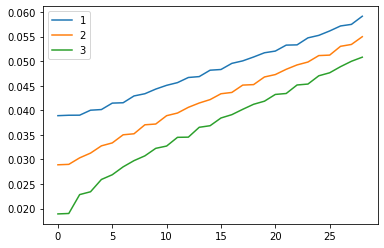

In [12]:
plt.figure()
plt.plot(t,coc_euro_k1_1,label="1")
plt.plot(t,coc_euro_k1_2,label="2")
plt.plot(t,coc_euro_k1_3,label="3")
plt.legend()
plt.show()

#### Compound American Call Option

In [13]:
def CRR_american_option_value_each_node(S0, K, T, r, sigma, otype, M):
    # 一.生成二叉树
    dt = T / M  # length of time interval
    df = np.exp(-r * dt)  # discount per interval
    inf = np.exp(r * dt)  # discount per interval

    # 计算udp
    u = np.exp(sigma * np.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability
    
    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    
    # 计算个节点单向变动时的股票价格
    mus = u ** (mu - md)
    mds = d ** md
    
    # 得到各节点的股票价格
    S = S0 * mus * mds 
        
    # 二.计算每个节点股票的预期价格
    mes = S0 * inf ** mu

    # 三.得到叶子结点的期权价值
    if otype == 'call':
        V = np.maximum(S - K, 0)     
        #计算每个节点提前行权的收益
        oreturn = mes - K
    else:
        V = np.maximum(K - S, 0)       
        #计算每个节点提前行权的收益
        oreturn = K - mes
    #return V
    # 四.逐步向前加权平均折现和提前行权的收益比较，得到期初期权价值
    for z in range(0, M):  # backwards iteration
        #计算后期折现的后期价格
        ovalue = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
        #逐列更新期权价值，相当于二叉树中的逐层向前折算
        #期权价格取后期折现和提前行权获得收益的最大值
        V[0:M - z, M - z - 1] = np.maximum(ovalue, oreturn[0:M - z, M - z - 1])
        
    return V

In [14]:
def coc_ame_price_each_node(S0,K1, K2, T1, T2, r, sigma, otype, M):
    ame_call_each_node=CRR_american_option_value_each_node(S0, K2, T2, r, sigma, otype, T2)
    p=prob_cal(S0,K2, T2, r, sigma, 'call', T2)
    S=np.zeros(T1+1)
    for i in np.arange(T1+1):
        S[i]=p**(T1-i)*(1-p)**i*np.max([ame_call_each_node[i,T1]-K1,0])*comb(10,i)
    present_value=np.sum(S)*np.exp(-r*T1)
    return(present_value)

In [15]:
def coc_ame_price(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    S_T1=coc_euro_price_fair_cal(S0, K1, T1, r, sigma, otype, M)
    K2=alpha*S_T1
    crr_v=CRR_american_option_value_each_node(S0,K2,T2,r,sigma,'call',T2)
    p=prob_cal(S0, T2, r, sigma, T2)
    t=np.arange(T1+1)
    price_each=np.zeros(T1+1)
    S=np.zeros(T1+1)
    for i in np.arange(T1+1):
        S[i]=p**(T1-i)*(1-p)**i*comb(T1,i)*np.max([crr_v[i,T1]-K1,0])
    present_value=np.sum(S)*np.exp(-r*T1)
    return(present_value)

In [16]:
t=np.arange(T2)
coc_ame_k1_1=np.zeros(T2)
coc_ame_k1_2=np.zeros(T2)
coc_ame_k1_3=np.zeros(T2)
for i in (np.arange(len(t))):
    coc_ame_k1_1[i]=coc_ame_price(S0,0.01,1,t[i], T2, risk_free, asset_volatility, 'call', T2)
    coc_ame_k1_2[i]=coc_ame_price(S0,0.03,1,t[i], T2, risk_free, asset_volatility, 'call', T2)
    coc_ame_k1_3[i]=coc_ame_price(S0,0.04,1,t[i], T2, risk_free, asset_volatility, 'call', T2)

C:\Users\91794\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


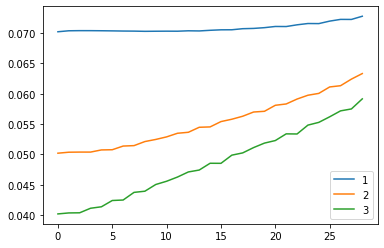

In [17]:
plt.figure()
plt.plot(t,coc_ame_k1_1,label="1")
plt.plot(t,coc_ame_k1_2,label="2")
plt.plot(t,coc_ame_k1_3,label="3")
plt.legend()
plt.show()

### Pricing Results (Binomial Tree Method)

In [18]:
print("The value of European Call on Call option with α=1 is",np.round(coc_euro_price(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print("The value of American Call on Call option with α=1 is",np.round(coc_ame_price(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))

The value of European Call on Call option with α=1 is 0.0389
The value of American Call on Call option with α=1 is 0.0394


In [19]:
print("The value of European Call on Call option with α=0.9 is",np.round(coc_euro_price(S0=S0,K1=0.05,alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print("The value of American Call on Call option with α=0.9 is",np.round(coc_ame_price(S0=S0,K1=0.05,alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))

The value of European Call on Call option with α=0.9 is 0.2189
The value of American Call on Call option with α=0.9 is 0.2877


In [20]:
print("The value of amepean Call on Call option with α=1.1 is",np.round(coc_euro_price(S0=S0,K1=0.05,alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print("The value of American Call on Call option with α=1.1 is",np.round(coc_ame_price(S0=S0,K1=0.05,alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))

The value of amepean Call on Call option with α=1.1 is 0.0006
The value of American Call on Call option with α=1.1 is 0.0006


In [21]:
table_price_bino=[["α=0.9","α=1","α=1.1"],
["European Call",
np.round(coc_euro_price(S0=S0,K1=0.05,alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0.05,alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)],
["American Call",
np.round(coc_ame_price(S0=S0,K1=0.05,alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_price(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_price(S0=S0,K1=0.05,alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)]]
print(tabulate(table_price_bino, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤═════════╤════════╤═════════╕
│               │   α=0.9 │    α=1 │   α=1.1 │
╞═══════════════╪═════════╪════════╪═════════╡
│ European Call │  0.2189 │ 0.0389 │  0.0006 │
├───────────────┼─────────┼────────┼─────────┤
│ American Call │  0.2877 │ 0.0394 │  0.0006 │
╘═══════════════╧═════════╧════════╧═════════╛


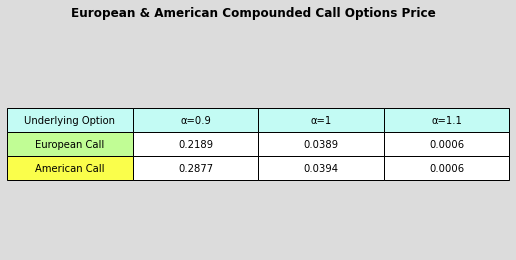

In [225]:
table_bino=[
["European Call",
np.round(coc_euro_price(S0=S0,K1=0.05,alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0.05,alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)],
["American Call",
np.round(coc_ame_price(S0=S0,K1=0.05,alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_price(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_price(S0=S0,K1=0.05,alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)]]
column_headers=["Underlying Option","α=0.9","α=1","α=1.1"]
cell_color=[['xkcd:celery','white','white','white'],
['xkcd:banana yellow','white','white','white']]
fig, ax = plt.subplots(facecolor='gainsboro') 
ax.set_axis_off() 
the_table = ax.table(cellText=table_bino,
                      colColours=['xkcd:duck egg blue']*4,
                      colLabels=column_headers,
                      loc='center',
                      cellLoc='center',
                      cellColours=cell_color)
plt.suptitle('European & American Compounded Call Options Price', fontweight ="bold") 
the_table.scale(1.5, 2)

## Simulation Option Price

### T1 and Price

In [226]:
t=np.arange(1,T2)
simu_euro_k_1=np.zeros(T2-1)
simu_euro_k_2=np.zeros(T2-1)
simu_euro_k_3=np.zeros(T2-1)
simu_ame_k_1=np.zeros(T2-1)
simu_ame_k_2=np.zeros(T2-1)
simu_ame_k_3=np.zeros(T2-1)
for i in range(len(t)):
    simu_euro_k_1[i]=coc_euro_price(S0=S0,K1=0.05,alpha=0.9,T1=t[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_euro_k_2[i]=coc_euro_price(S0=S0,K1=0.05,alpha=1,T1=t[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_euro_k_3[i]=coc_euro_price(S0=S0,K1=0.05,alpha=1.1,T1=t[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_1[i]=coc_ame_price(S0=S0,K1=0.05,alpha=0.9,T1=t[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_2[i]=coc_ame_price(S0=S0,K1=0.05,alpha=1,T1=t[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_3[i]=coc_ame_price(S0=S0,K1=0.05,alpha=1.1,T1=t[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)

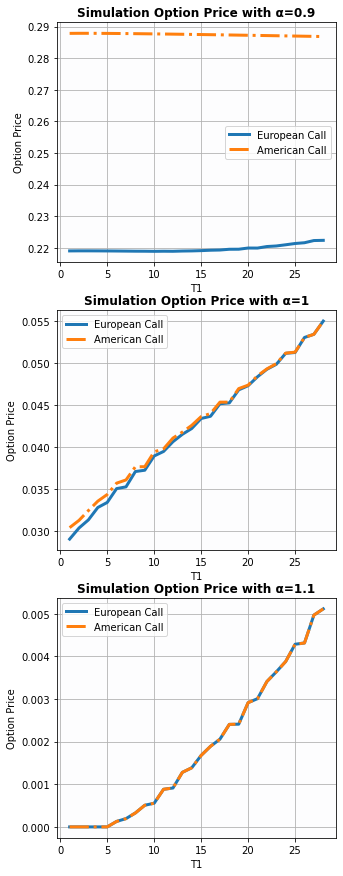

In [227]:
plt.figure(figsize=(5,15))
plt.subplot(3,1,1,facecolor='xkcd:pale grey')
plt.plot(t,simu_euro_k_1,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t,simu_ame_k_1,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=0.9",fontweight ="bold")
plt.xlabel("T1")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.subplot(3,1,2,facecolor='xkcd:pale grey')
plt.plot(t,simu_euro_k_2,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t,simu_ame_k_2,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=1",fontweight ="bold")
plt.xlabel("T1")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.subplot(3,1,3,facecolor='xkcd:pale grey')
plt.plot(t,simu_euro_k_3,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t,simu_ame_k_3,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=1.1",fontweight ="bold")
plt.xlabel("T1")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.show()

### S0 and Price

In [228]:
S0_simulation=np.linspace(1,4,500)
simu_euro_k_1=np.zeros(500)
simu_euro_k_2=np.zeros(500)
simu_euro_k_3=np.zeros(500)
simu_ame_k_1=np.zeros(500)
simu_ame_k_2=np.zeros(500)
simu_ame_k_3=np.zeros(500)
for i in range(len(S0_simulation)):
    simu_euro_k_1[i-1]=coc_euro_price(S0_simulation[i-1],K1=0.05,alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_euro_k_2[i-1]=coc_euro_price(S0_simulation[i-1],K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_euro_k_3[i-1]=coc_euro_price(S0_simulation[i-1],K1=0.05,alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_1[i-1]=coc_ame_price(S0_simulation[i-1],K1=0.05,alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_2[i-1]=coc_ame_price(S0_simulation[i-1],K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_3[i-1]=coc_ame_price(S0_simulation[i-1],K1=0.05,alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)

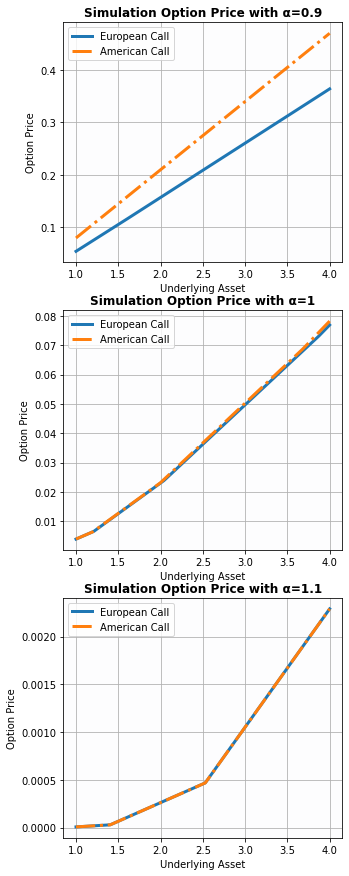

In [229]:
plt.figure(figsize=(5,15))
plt.subplot(3,1,1,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,simu_euro_k_1,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,simu_ame_k_1,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=0.9",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.subplot(3,1,2,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,simu_euro_k_2,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,simu_ame_k_2,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=1",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.subplot(3,1,3,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,simu_euro_k_3,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,simu_ame_k_3,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=1.1",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.show()

### T2 and Price

In [230]:
t=np.arange(T1+1,T2+1)
simu_euro_k_1=np.zeros(T2-T1)
simu_euro_k_2=np.zeros(T2-T1)
simu_euro_k_3=np.zeros(T2-T1)
simu_ame_k_1=np.zeros(T2-T1)
simu_ame_k_2=np.zeros(T2-T1)
simu_ame_k_3=np.zeros(T2-T1)
for i in range(len(t)):
    simu_euro_k_1[i]=coc_euro_price(S0=S0,K1=0.05,alpha=0.9,T1=T1,T2=t[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_euro_k_2[i]=coc_euro_price(S0=S0,K1=0.05,alpha=1,T1=T1,T2=t[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_euro_k_3[i]=coc_euro_price(S0=S0,K1=0.05,alpha=1.1,T1=T1,T2=t[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_1[i]=coc_ame_price(S0=S0,K1=0.05,alpha=0.9,T1=T1,T2=t[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_2[i]=coc_ame_price(S0=S0,K1=0.05,alpha=1,T1=T1,T2=t[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_3[i]=coc_ame_price(S0=S0,K1=0.05,alpha=1.1,T1=T1,T2=t[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)

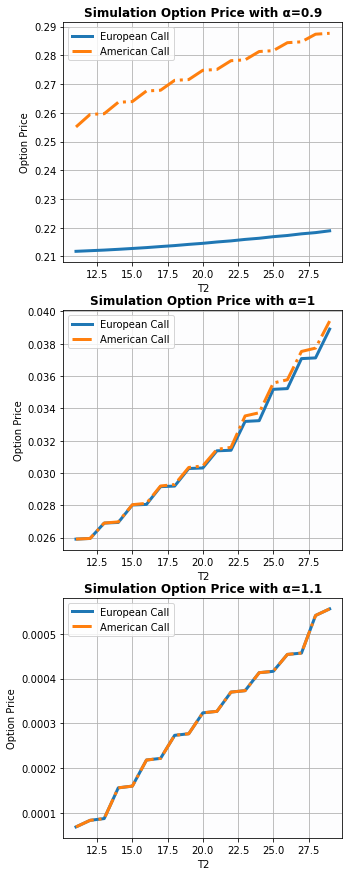

In [231]:
plt.figure(figsize=(5,15))
plt.subplot(3,1,1,facecolor='xkcd:pale grey')
plt.plot(t,simu_euro_k_1,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t,simu_ame_k_1,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=0.9",fontweight ="bold")
plt.xlabel("T2")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.subplot(3,1,2,facecolor='xkcd:pale grey')
plt.plot(t,simu_euro_k_2,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t,simu_ame_k_2,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=1",fontweight ="bold")
plt.xlabel("T2")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.subplot(3,1,3,facecolor='xkcd:pale grey')
plt.plot(t,simu_euro_k_3,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t,simu_ame_k_3,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=1.1",fontweight ="bold")
plt.xlabel("T2")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.show()

### K1 and Price

In [232]:
k1_simulation=np.linspace(0,0.1,10)
T=29
simu_euro_k_1=np.zeros(10)
simu_euro_k_2=np.zeros(10)
simu_euro_k_3=np.zeros(10)
simu_ame_k_1=np.zeros(10)
simu_ame_k_2=np.zeros(10)
simu_ame_k_3=np.zeros(10)
for i in range(len(k1_simulation)):
    simu_euro_k_1[i]=coc_euro_price(S0=S0,K1=k1_simulation[i],alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_euro_k_2[i]=coc_euro_price(S0=S0,K1=k1_simulation[i],alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_euro_k_3[i]=coc_euro_price(S0=S0,K1=k1_simulation[i],alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_1[i]=coc_ame_price(S0=S0,K1=k1_simulation[i],alpha=0.9,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_2[i]=coc_ame_price(S0=S0,K1=k1_simulation[i],alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_3[i]=coc_ame_price(S0=S0,K1=k1_simulation[i],alpha=1.1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)

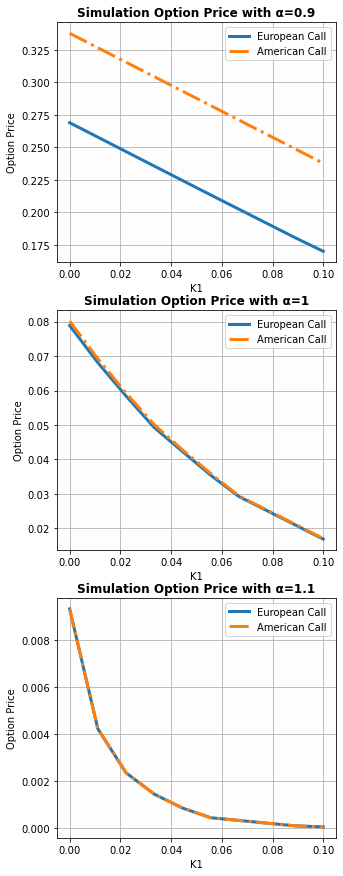

In [233]:
plt.figure(figsize=(5,15))
plt.subplot(3,1,1,facecolor='xkcd:pale grey')
plt.plot(k1_simulation,simu_euro_k_1,linestyle="solid",linewidth=3,label='European Call')
plt.plot(k1_simulation,simu_ame_k_1,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=0.9",fontweight ="bold")
plt.xlabel("K1")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.subplot(3,1,2,facecolor='xkcd:pale grey')
plt.plot(k1_simulation,simu_euro_k_2,linestyle="solid",linewidth=3,label='European Call')
plt.plot(k1_simulation,simu_ame_k_2,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=1",fontweight ="bold")
plt.xlabel("K1")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.subplot(3,1,3,facecolor='xkcd:pale grey')
plt.plot(k1_simulation,simu_euro_k_3,linestyle="solid",linewidth=3,label='European Call')
plt.plot(k1_simulation,simu_ame_k_3,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with α=1.1",fontweight ="bold")
plt.xlabel("K1")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.show()

### Alpha and Price

In [234]:
alpha_simulation=np.linspace(0.2,2,10)
simu_euro_k_1=np.zeros(10)
simu_ame_k_1=np.zeros(10)
for i in range(len(alpha_simulation)):
    simu_euro_k_1[i]=coc_euro_price(S0=S0,K1=0,alpha=alpha_simulation[i],T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    simu_ame_k_1[i]=coc_ame_price(S0=S0,K1=0,alpha=alpha_simulation[i],T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)

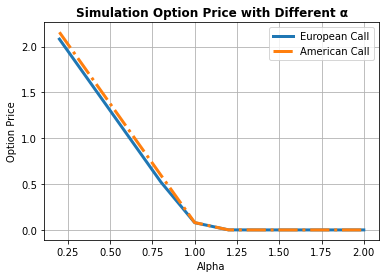

In [235]:
plt.figure()
plt.plot(alpha_simulation,simu_euro_k_1,linestyle="solid",linewidth=3,label='European Call')
plt.plot(alpha_simulation,simu_ame_k_1,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with Different α",fontweight ="bold")
plt.xlabel("Alpha")
plt.ylabel("Option Price")
plt.legend()
plt.grid()
plt.show()

#### Underlying Option Simulation (Additional)

In [236]:
S0_simulation=np.linspace(1,4,500)
simu_euro_k_1=np.zeros(500)
simu_euro_k_2=np.zeros(500)
simu_euro_k_3=np.zeros(500)
simu_ame_k_1=np.zeros(500)
simu_ame_k_2=np.zeros(500)
simu_ame_k_3=np.zeros(500)
for i in range(len(S0_simulation)):
    simu_euro_k_1[i-1]=CRR_european_option_value(S0_simulation[i-1],k_1, T2, risk_free, asset_volatility, 'call', T2)
    simu_euro_k_2[i-1]=CRR_european_option_value(S0_simulation[i-1], k_2, T2, risk_free, asset_volatility, 'call', T2)
    simu_euro_k_3[i-1]=CRR_european_option_value(S0_simulation[i-1], k_3, T2, risk_free, asset_volatility, 'call', T2)
    simu_ame_k_1[i-1]=CRR_american_option_value(S0_simulation[i-1],k_1, T2, risk_free, asset_volatility, 'call', T2)
    simu_ame_k_2[i-1]=CRR_american_option_value(S0_simulation[i-1],k_1, T2, risk_free, asset_volatility, 'call', T2)
    simu_ame_k_3[i-1]=CRR_american_option_value(S0_simulation[i-1],k_1, T2, risk_free, asset_volatility, 'call', T2)

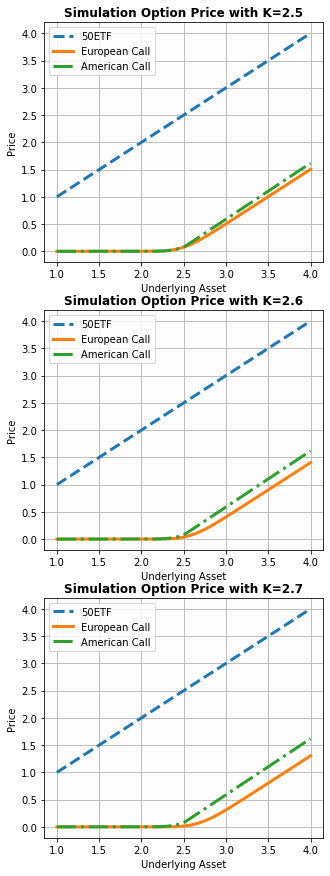

In [237]:
plt.figure(figsize=(5,15))
plt.subplot(3,1,1,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,S0_simulation,linestyle="dashed",linewidth=3,label='50ETF')
plt.plot(S0_simulation,simu_euro_k_1,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,simu_ame_k_1,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with K=2.5",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.subplot(3,1,2,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,S0_simulation,linestyle="dashed",linewidth=3,label='50ETF')
plt.plot(S0_simulation,simu_euro_k_2,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,simu_ame_k_2,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with K=2.6",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.subplot(3,1,3,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,S0_simulation,linestyle="dashed",linewidth=3,label='50ETF')
plt.plot(S0_simulation,simu_euro_k_3,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,simu_ame_k_3,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Option Price with K=2.7",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

## BSM Models and Monte Carlo

In [238]:
data = pd.read_excel('上证50看涨期权数据.xlsx').iloc[:-2]
stock_price = data[['日期','标的收盘价(元)']]
stock_price.columns = ['date','stock_price']
stock_price = stock_price.set_index('date')
call_price = data[['日期','50ETF购12月2500','50ETF购12月2650','50ETF购12月2800']]
call_price.columns = ['date','k_2500','k_2650','k_2800']
call_price = call_price.set_index('date')
stock_price.index = pd.to_datetime(stock_price.index,format="%Y%m%d")
call_price.index = pd.to_datetime(call_price.index,format="%Y%m%d")

In [26]:
# S: original price of stock S
# v: annualized volatility
# r: annualized risk free rate
# tau: time to expiration
def calculate_S_T(S, v, r, tau):
    return S * exp((r - 0.5 * v ** 2) * tau + v * sqrt(tau) * gauss(0.0, 1.0))
# flag is one of call or put
# S_T is the lognormal stock price at time T
# alpha_S*S_T is the strike price of S_T, the strike price is alpha_S times of S_T
def option_payoff(flag, S_T, strike_S):
    if flag == 'call':
        # for a call option with alpha less than 1.0, the strike price is smaller than S_T, the payoff is positive
        return max(S_T - strike_S, 0.0) 
    elif flag == 'put':
        return max(strike_S - S_T, 0.0)


def option_on_option_payoff(flag_S, flag_OP,
                            T_X,T_underlying,
                            alpha_S, strike_X,
                            S0, v, r):
    # flag_S is for the option with stock as the underlying asset, call or put
    # flag_OP is for the option with another option as the underlying asset, call or put
    # S_T is the lognormal stock price at time T
    # alpha_S is the multiplier of the option underlying stock
    # strike_X is the strike price of the option on option, which is Derivative X
    
    S_T_X = calculate_S_T(S0,v,r,T_X) # stock price at time T_X
    strike_S = alpha_S * S_T_X # strike price of the underlying option

    S_T_underlying = calculate_S_T(S0,v,r,T_underlying) # stock price at time T_underlying
    C_T_underlying = option_payoff(flag_S, S_T_underlying, strike_S) # the payoff at time T_underlying

    Tau = T_underlying - T_X # time period from Derivative X expiration to call option expiration
    discount_X_to_underlying = exp(-r * Tau)
    C_T_X = discount_X_to_underlying * C_T_underlying # payoff at the time T_X
    # if Derivative X is a call option
    # when alpha_X is less than 1.0, the strike price alpha_X * C is smaller than C, the payoff is positive

    if flag_OP == 'call':
        return max(C_T_X-strike_X,0)


def value_monte_carlo(flag_S, flag_OP,
                      T_underlying, T_X, simulations,
                      S0, v, r,
                      alpha_S, strike_X):
    payoffs = []

    for i in range(simulations):
        # S_T_X = calculate_S_T(S, v, r, T_X)# S is at time 0, S_TX is at T_X
        payoffs.append(
            option_on_option_payoff(flag_S='call', flag_OP='call',
                                    T_X=T_X, T_underlying=T_underlying,
                                    alpha_S=alpha_S, strike_X=strike_X,
                                    S0=S0,v=v,r=r)
        )
    value_T_X = sum(payoffs) / float(simulations)

    discount_zero_to_T_X = exp(-r * T_X)

    value_T_0 = discount_zero_to_T_X * value_T_X
    
    print('Alpha={}'.format(alpha_S))
    print('Value X at the expiration time is {:.4f}'.format(value_T_X))
    print('Value X at time zero is {:.4f}'.format(value_T_0))
    return value_T_0


In [27]:
# volitility
asset_return=np.diff(np.log(data.iloc[2:60,4]))
v = np.std(asset_return) * sqrt(252)
# stock price on 2022-11-17
# S = stock_price.iloc[1][0]
S0 = 2.6
# annualized risk free interest rate
# r = 0.000041 * 252 
r=0.015
# annualized time
T_X = 10 / 252
T_underlying = 29 / 252

# alpha_S = 0.5
strike_X = 0
simulations_list = [10,50,100,500,1000]

coord_alpha = [a/10.0 for a in range(1,21,1)]
coord_X_value = [[] for _ in range(len(simulations_list))]
for i, simulations in enumerate(simulations_list):
    for a in coord_alpha:
        alpha_S = a 
        v_0 = value_monte_carlo('call','call',
                        T_underlying, T_X, simulations,
                        S0, v, r,
                        alpha_S, strike_X)
        coord_X_value[i].append(v_0)

Alpha=0.1
Value X at the expiration time is 2.3542
Value X at time zero is 2.3528
Alpha=0.2
Value X at the expiration time is 2.0712
Value X at time zero is 2.0700
Alpha=0.3
Value X at the expiration time is 1.8396
Value X at time zero is 1.8385
Alpha=0.4
Value X at the expiration time is 1.6178
Value X at time zero is 1.6168
Alpha=0.5
Value X at the expiration time is 1.2708
Value X at time zero is 1.2701
Alpha=0.6
Value X at the expiration time is 1.1095
Value X at time zero is 1.1089
Alpha=0.7
Value X at the expiration time is 0.7956
Value X at time zero is 0.7952
Alpha=0.8
Value X at the expiration time is 0.5213
Value X at time zero is 0.5210
Alpha=0.9
Value X at the expiration time is 0.3075
Value X at time zero is 0.3073
Alpha=1.0
Value X at the expiration time is 0.0589
Value X at time zero is 0.0589
Alpha=1.1
Value X at the expiration time is 0.1063
Value X at time zero is 0.1063
Alpha=1.2
Value X at the expiration time is 0.0000
Value X at time zero is 0.0000
Alpha=1.3
Value 

In [28]:
for i in zip(coord_alpha, coord_X_value[-1]):
    print(i)

(0.1, 2.3349890540527483)
(0.2, 2.077834416533325)
(0.3, 1.8183995040656995)
(0.4, 1.5584293147864836)
(0.5, 1.3038952120203922)
(0.6, 1.0451215584990154)
(0.7, 0.7988256150468619)
(0.8, 0.517939485768657)
(0.9, 0.2659746644689393)
(1.0, 0.08914857099290727)
(1.1, 0.016135137847715142)
(1.2, 0.0015166037092195176)
(1.3, 6.720481840008464e-05)
(1.4, 1.6668560715580775e-05)
(1.5, 0.0)
(1.6, 0.0)
(1.7, 0.0)
(1.8, 0.0)
(1.9, 0.0)
(2.0, 0.0)


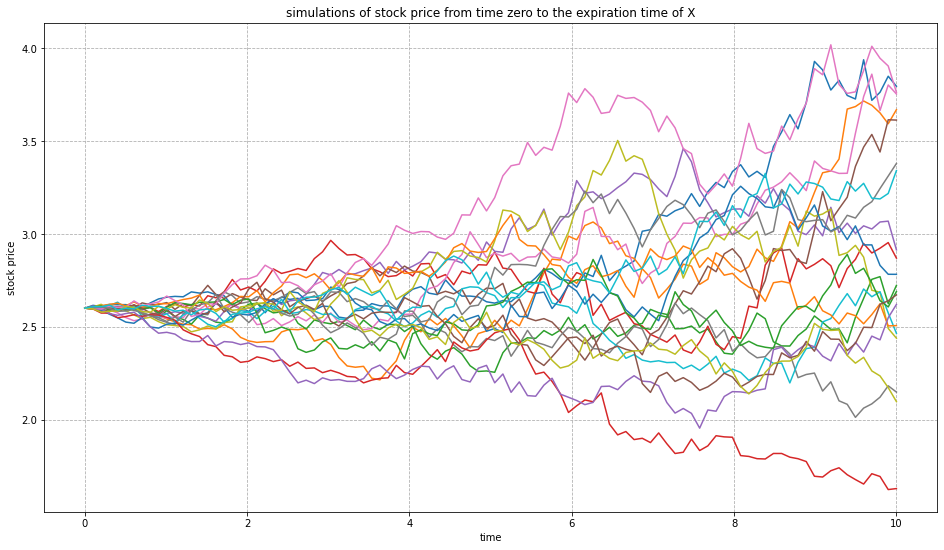

In [241]:
# plot the simulations of the stock price
import matplotlib.pyplot as plt 
import numpy as np
fig = plt.figure(figsize=(16,9))
ax = plt.axes()
for i in range(30):
    S_price_sequence=[]
    S = S0
    x = np.linspace(0,29,100)
    for t in x:
        S = calculate_S_T(S,v,r,t/252)
        S_price_sequence.append(S)
    ax.set(xlabel='time',
           ylabel='stock price',
           title='simulations of stock price from time zero to the expiration time of X')
    ax.grid(True,linestyle='--')
    ax.plot(x,S_price_sequence)

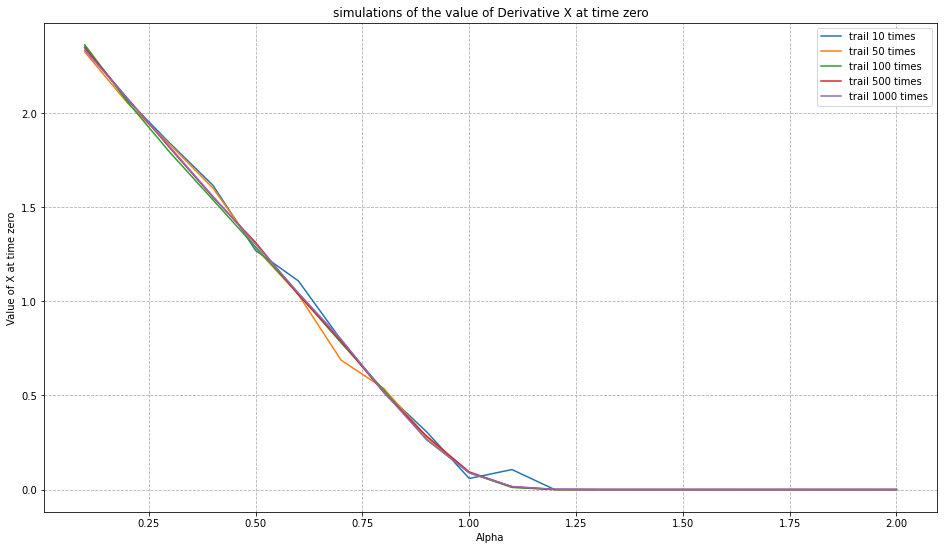

In [29]:
from matplotlib.pyplot import xlabel, ylabel


fig2 = plt.figure(figsize=(16,9))
ax2 = plt.axes()
for x_value, simulation in zip(coord_X_value, simulations_list):
    ax2.plot(coord_alpha, x_value,label="trail {} times".format(simulation))
ax2.set(xlabel='Alpha',ylabel='Value of X at time zero',
        title='simulations of the value of Derivative X at time zero')
ax2.grid(True,linestyle='--')
ax2.legend()

## CoC Greek Letters (European Call)

In [242]:
def coc_euro_delta_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P10=coc_euro_price(S0*1.01,K1, alpha, T1, T2, r, sigma, otype, M)
    P11=coc_euro_price(S0/1.01,K1, alpha, T1, T2, r, sigma, otype, M)
    S10=S0*1.01
    S11=S0/1.01
    delta=(P10-P11)/(S10-S11)
    return(delta)

def coc_euro_gamma_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P20=coc_euro_price(S0*1.01**2,K1, alpha, T1, T2, r, sigma, otype, M)
    P21=coc_euro_price(S0,K1, alpha, T1, T2, r, sigma, otype, M)
    P22=coc_euro_price(S0/(1.01**2),K1, alpha, T1, T2, r, sigma, otype, M)
    S20=S0*1.01**2
    S21=S0
    S22=S0/(1.01**2)
    gamma=((P20-P21)/(S20-S21)-(P21-P22)/(S21-S22))/((S20-S22)/2)
    return(gamma)

def coc_euro_theta_t1_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P10=coc_euro_price(S0,K1, alpha, T1+1, T2, r, sigma, otype, M)
    P11=coc_euro_price(S0,K1, alpha, T1, T2, r, sigma, otype, M)
    theta_t1=P10-P11
    return(theta_t1)

def coc_euro_theta_t2_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P10=coc_euro_price(S0,K1, alpha, T1, T2+1, r, sigma, otype, M)
    P11=coc_euro_price(S0,K1, alpha, T1, T2, r, sigma, otype, M)
    theta_t2=P10-P11
    return(theta_t2)

def coc_euro_vega_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P10=coc_euro_price(S0,K1, alpha, T1, T2, r, sigma*1.01, otype, M)
    P11=coc_euro_price(S0,K1, alpha, T1, T2, r, sigma, otype, M)
    V10=sigma*1.01
    V11=sigma
    vega=(P10-P11)/(V10-V11)
    return(vega)

In [243]:
print(np.round(coc_euro_delta_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print(np.round(coc_euro_gamma_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print(np.round(coc_euro_theta_t1_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print(np.round(coc_euro_theta_t2_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print(np.round(coc_euro_vega_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))

0.0268
0.0
0.0005
0.0
5.0527


## CoC Greek Letter American

In [244]:
def coc_ame_delta_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P10=coc_ame_price(S0*1.01,K1, alpha, T1, T2, r, sigma, otype, M)
    P11=coc_ame_price(S0/1.01,K1, alpha, T1, T2, r, sigma, otype, M)
    S10=S0*1.01
    S11=S0/1.01
    delta=(P10-P11)/(S10-S11)
    return(delta)

def coc_ame_gamma_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P20=coc_ame_price(S0*1.01**2,K1, alpha, T1, T2, r, sigma, otype, M)
    P21=coc_ame_price(S0,K1, alpha, T1, T2, r, sigma, otype, M)
    P22=coc_ame_price(S0/(1.01**2),K1, alpha, T1, T2, r, sigma, otype, M)
    S20=S0*1.01**2
    S21=S0
    S22=S0/(1.01**2)
    gamma=((P20-P21)/(S20-S21)-(P21-P22)/(S21-S22))/((S20-S22)/2)
    return(gamma)

def coc_ame_theta_t1_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P10=coc_ame_price(S0,K1, alpha, T1+1, T2, r, sigma, otype, M)
    P11=coc_ame_price(S0,K1, alpha, T1, T2, r, sigma, otype, M)
    theta_t1=P10-P11
    return(theta_t1)

def coc_ame_theta_t2_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P10=coc_ame_price(S0,K1, alpha, T1, T2+1, r, sigma, otype, M)
    P11=coc_ame_price(S0,K1, alpha, T1, T2, r, sigma, otype, M)
    theta_t2=P10-P11
    return(theta_t2)

def coc_ame_vega_cal(S0,K1, alpha, T1, T2, r, sigma, otype, M):
    P10=coc_ame_price(S0,K1, alpha, T1, T2, r, sigma*1.01, otype, M)
    P11=coc_ame_price(S0,K1, alpha, T1, T2, r, sigma, otype, M)
    V10=sigma*1.01
    V11=sigma
    vega=(P10-P11)/(V10-V11)
    return(vega)

In [245]:
print(np.round(coc_ame_delta_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print(np.round(coc_ame_gamma_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print(np.round(coc_ame_theta_t1_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print(np.round(coc_ame_theta_t2_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))
print(np.round(coc_ame_vega_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4))

0.027
0.0
0.0003
0.0002
5.0686


In [246]:
table_greek=[["Greek Letters","European Compound Call","American Compound Call"],
["Delta",
np.round(coc_euro_delta_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_delta_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)],
["Gamma",
np.round(coc_euro_gamma_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_gamma_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)],
["Theta_T1",
np.round(coc_euro_theta_t1_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_theta_t1_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)],
["Theta_T2",
np.round(coc_euro_theta_t2_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_theta_t2_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)],
["Vega",
np.round(coc_euro_vega_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4),
np.round(coc_ame_vega_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2),4)]]
print(tabulate(table_greek, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════╤══════════════════════════╤══════════════════════════╕
│ Greek Letters   │   European Compound Call │   American Compound Call │
╞═════════════════╪══════════════════════════╪══════════════════════════╡
│ Delta           │                   0.0268 │                   0.027  │
├─────────────────┼──────────────────────────┼──────────────────────────┤
│ Gamma           │                   0      │                   0      │
├─────────────────┼──────────────────────────┼──────────────────────────┤
│ Theta_T1        │                   0.0005 │                   0.0003 │
├─────────────────┼──────────────────────────┼──────────────────────────┤
│ Theta_T2        │                   0      │                   0.0002 │
├─────────────────┼──────────────────────────┼──────────────────────────┤
│ Vega            │                   5.0527 │                   5.0686 │
╘═════════════════╧══════════════════════════╧══════════════════════════╛


### Simulation COC (Additional)

In [247]:
S0_simulation=np.linspace(1,4,500)
delta_simu_euro=np.zeros(500)
delta_simu_ame=np.zeros(500)
gamma_simu_euro=np.zeros(500)
gamma_simu_ame=np.zeros(500)
for i in range(len(S0_simulation)):
    delta_simu_ame[i-1]=coc_ame_delta_cal(S0=S0_simulation[i-1],K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    delta_simu_euro[i-1]=coc_euro_delta_cal(S0=S0_simulation[i-1],K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    gamma_simu_euro[i-1]=coc_euro_gamma_cal(S0=S0_simulation[i-1],K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    gamma_simu_ame[i-1]=coc_ame_gamma_cal(S0=S0_simulation[i-1],K1=0.05,alpha=1,T1=T1,T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)

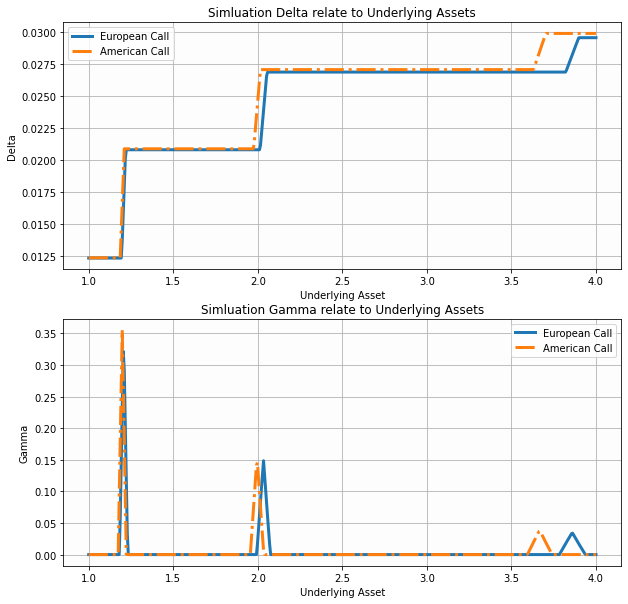

In [248]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,delta_simu_euro,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,delta_simu_ame,linestyle="dashdot",linewidth=3,label='American Call')
plt.legend()
plt.xlabel("Underlying Asset")
plt.ylabel("Delta")
plt.title("Simluation Delta relate to Underlying Assets")
plt.grid()
plt.subplot(2,1,2,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,gamma_simu_euro,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,gamma_simu_ame,linestyle="dashdot",linewidth=3,label='American Call')
plt.legend()
plt.xlabel("Underlying Asset")
plt.ylabel("Gamma")
plt.title("Simluation Gamma relate to Underlying Assets")
plt.grid()

减少K1或Alpha，delta上移且波动减小，Gamma波动缩小且节点延后

In [249]:
t1_simulation=np.arange(1,T2)
t2_simulation=np.arange(T1+1,T2+1)
theta_t1_simu_euro=np.zeros(T2-1)
theta_t1_simu_ame=np.zeros(T2-1)
theta_t2_simu_euro=np.zeros(T2-T1)
theta_t2_simu_ame=np.zeros(T2-T1)
for i in range(len(t1_simulation)):
    theta_t1_simu_ame[i]=coc_ame_theta_t1_cal(S0=S0,K1=0.05,alpha=1,T1=t1_simulation[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    theta_t1_simu_euro[i]=coc_euro_theta_t1_cal(S0=S0,K1=0.05,alpha=1,T1=t1_simulation[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
for i in range(len(t2_simulation)):
    theta_t2_simu_euro[i]=coc_euro_theta_t2_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=t2_simulation[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    theta_t2_simu_ame[i]=coc_ame_theta_t2_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=t2_simulation[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)

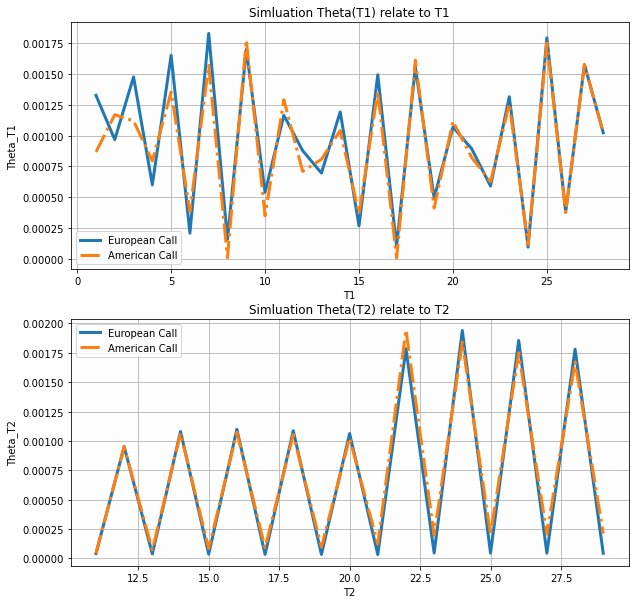

In [250]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1,facecolor='xkcd:pale grey')
plt.plot(t1_simulation,theta_t1_simu_euro,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t1_simulation,theta_t1_simu_ame,linestyle="dashdot",linewidth=3,label='American Call')
plt.legend()
plt.xlabel("T1")
plt.ylabel("Theta_T1")
plt.title("Simluation Theta(T1) relate to T1")
plt.grid()
plt.subplot(2,1,2,facecolor='xkcd:pale grey')
plt.plot(t2_simulation,theta_t2_simu_euro,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t2_simulation,theta_t2_simu_ame,linestyle="dashdot",linewidth=3,label='American Call')
plt.legend()
plt.xlabel("T2")
plt.ylabel("Theta_T2")
plt.title("Simluation Theta(T2) relate to T2")
plt.grid()

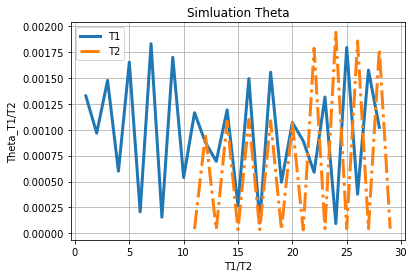

In [251]:
plt.figure()
plt.plot(t1_simulation,theta_t1_simu_euro,linestyle="solid",linewidth=3,label='T1')
plt.plot(t2_simulation,theta_t2_simu_euro,linestyle="dashdot",linewidth=3,label='T2')
plt.legend()
plt.xlabel("T1/T2")
plt.ylabel("Theta_T1/T2")
plt.title("Simluation Theta")
plt.grid()

In [252]:
t1_simulation=np.arange(1,T2)
t2_simulation=np.arange(T1+1,T2+1)
vega_t1_simu_euro=np.zeros(T2-1)
vega_t1_simu_ame=np.zeros(T2-1)
vega_t2_simu_euro=np.zeros(T2-T1)
vega_t2_simu_ame=np.zeros(T2-T1)
for i in range(len(t1_simulation)):
    vega_t1_simu_ame[i]=coc_ame_vega_cal(S0=S0,K1=0.05,alpha=1,T1=t1_simulation[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    vega_t1_simu_euro[i]=coc_euro_vega_cal(S0=S0,K1=0.05,alpha=1,T1=t1_simulation[i],T2=T2,r=risk_free,sigma=asset_volatility,otype='call',M=T2)
for i in range(len(t2_simulation)):
    vega_t2_simu_euro[i]=coc_euro_vega_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=t2_simulation[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)
    vega_t2_simu_ame[i]=coc_ame_vega_cal(S0=S0,K1=0.05,alpha=1,T1=T1,T2=t2_simulation[i],r=risk_free,sigma=asset_volatility,otype='call',M=T2)

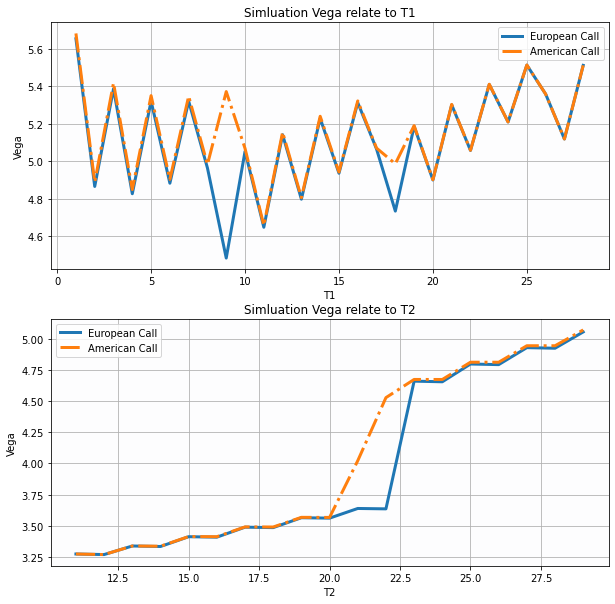

In [253]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1,facecolor='xkcd:pale grey')
plt.plot(t1_simulation,vega_t1_simu_euro,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t1_simulation,vega_t1_simu_ame,linestyle="dashdot",linewidth=3,label='American Call')
plt.legend()
plt.xlabel("T1")
plt.ylabel("Vega")
plt.title("Simluation Vega relate to T1")
plt.grid()
plt.subplot(2,1,2,facecolor='xkcd:pale grey')
plt.plot(t2_simulation,vega_t2_simu_euro,linestyle="solid",linewidth=3,label='European Call')
plt.plot(t2_simulation,vega_t2_simu_ame,linestyle="dashdot",linewidth=3,label='American Call')
plt.legend()
plt.xlabel("T2")
plt.ylabel("Vega")
plt.title("Simluation Vega relate to T2")
plt.grid()

### Underlying Option Greek Letters (Additional)

In [254]:
n = norm.pdf
N = norm.cdf

def european_delta_cal(S0, K, T, r, sigma):
    d1=(np.log(S0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    delta=N(d1)
    return(delta)

def european_gamma_cal(S0, K, T, r, sigma):
    d1=(np.log(S0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    gamma=np.exp(-d1**2/2)/(S0*sigma*np.sqrt(2*np.pi*T))
    return (gamma)

def european_theta_cal(S0, K, T, r, sigma):
    d1=(np.log(S0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    theta=-(S0*sigma*np.exp(-d1**2/2))/(2*np.sqrt(2*np.pi*T)) - r*K*np.exp(-r*T)*N(d2)
    return(theta)

def european_vega_cal(S0, K, T, r, sigma):
    d1=(np.log(S0/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    vega=S0*np.sqrt(T)*n(d1,0,1)
    return(vega/100)


Delta

In [255]:
european_delta_k_1=european_delta_cal(S0,k_1, T2, risk_free, asset_volatility)
european_delta_k_2=european_delta_cal(S0,k_2, T2, risk_free, asset_volatility)
european_delta_k_3=european_delta_cal(S0,k_3, T2, risk_free, asset_volatility)

Gamma

In [256]:
european_gamma_k_1=european_gamma_cal(S0,k_1, T2, risk_free, asset_volatility)
european_gamma_k_2=european_gamma_cal(S0,k_2, T2, risk_free, asset_volatility)
european_gamma_k_3=european_gamma_cal(S0,k_3, T2, risk_free, asset_volatility)

Theta

In [257]:
european_theta_k_1=european_theta_cal(S0,k_1, T2, risk_free, asset_volatility)
european_theta_k_2=european_theta_cal(S0,k_2, T2, risk_free, asset_volatility)
european_theta_k_3=european_theta_cal(S0,k_3, T2, risk_free, asset_volatility)

Vega

In [258]:
european_vega_k_1=european_vega_cal(S0,k_1, T2, risk_free, asset_volatility)
european_vega_k_2=european_vega_cal(S0,k_2, T2, risk_free, asset_volatility)
european_vega_k_3=european_vega_cal(S0,k_3, T2, risk_free, asset_volatility)
european_vega_k_1

0.04712557300190477

In [259]:
table_greek_european=[["K=2.5","K=2.6","K=2.7"],
["Delta",
np.round(european_delta_k_1,4),
np.round(european_delta_k_2,4),
np.round(european_delta_k_3,4)],
["Gamma",
np.round(european_gamma_k_1,4),
np.round(european_gamma_k_2,4),
np.round(european_gamma_k_3,4)],
["Theta",
np.round(european_theta_k_1,4),
np.round(european_theta_k_2,4),
np.round(european_theta_k_3,4)],
["Vega",
np.round(european_vega_k_1,4),
np.round(european_vega_k_2,4),
np.round(european_vega_k_3,4)]]
print(tabulate(table_greek_european, headers='firstrow', tablefmt='fancy_grid'))

╒═══════╤═════════╤═════════╤═════════╕
│       │   K=2.5 │   K=2.6 │   K=2.7 │
╞═══════╪═════════╪═════════╪═════════╡
│ Delta │  0.7201 │  0.5212 │  0.3239 │
├───────┼─────────┼─────────┼─────────┤
│ Gamma │  1.7494 │  2.0706 │  1.868  │
├───────┼─────────┼─────────┼─────────┤
│ Theta │ -0.0012 │ -0.0014 │ -0.0012 │
├───────┼─────────┼─────────┼─────────┤
│ Vega  │  0.0471 │  0.0558 │  0.0503 │
╘═══════╧═════════╧═════════╧═════════╛


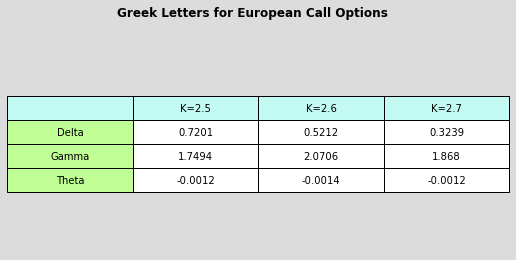

In [260]:
table_greek_euo=[
['Delta',
np.round(european_delta_k_1,4),
np.round(european_delta_k_2,4),
np.round(european_delta_k_3,4)],
['Gamma',
np.round(european_gamma_k_1,4),
np.round(european_gamma_k_2,4),
np.round(european_gamma_k_3,4)],
['Theta',
np.round(european_theta_k_1,4),
np.round(european_theta_k_2,4),
np.round(european_theta_k_3,4)]]
column_headers=['',"K=2.5","K=2.6","K=2.7"]
cell_color=[['xkcd:celery','white','white','white'],
['xkcd:celery','white','white','white'],
['xkcd:celery','white','white','white']]
fig, ax = plt.subplots(facecolor='gainsboro') 
ax.set_axis_off() 
the_table = ax.table(cellText=table_greek_euo,
                      colColours=['xkcd:duck egg blue']*4,
                      colLabels=column_headers,
                      loc='center',
                      cellLoc='center',
                      cellColours=cell_color,
                      )
plt.suptitle('Greek Letters for European Call Options', fontweight ="bold") 
the_table.scale(1.5, 2)

#### Underlying American Option Greek Letters

In [261]:
def CRR_american_option_value_each_node(S0, K, T, r, sigma, otype, M):
    # 一.生成二叉树
    dt = T / M  # length of time interval
    df = np.exp(-r * dt)  # discount per interval
    inf = np.exp(r * dt)  # discount per interval

    # 计算udp
    u = np.exp(sigma * np.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability
    
    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    
    # 计算个节点单向变动时的股票价格
    mus = u ** (mu - md)
    mds = d ** md
    
    # 得到各节点的股票价格
    S = S0 * mus * mds 
        
    # 二.计算每个节点股票的预期价格
    mes = S0 * inf ** mu

    # 三.得到叶子结点的期权价值
    if otype == 'call':
        V = np.maximum(S - K, 0)     
        #计算每个节点提前行权的收益
        oreturn = mes - K
    else:
        V = np.maximum(K - S, 0)       
        #计算每个节点提前行权的收益
        oreturn = K - mes
    return V
    # 四.逐步向前加权平均折现和提前行权的收益比较，得到期初期权价值
    for z in range(0, M):  # backwards iteration
        #计算后期折现的后期价格
        ovalue = (q * V[0:M - z, M - z] +
                         (1 - q) * V[1:M - z + 1, M - z]) * df
        #逐列更新期权价值，相当于二叉树中的逐层向前折算
        #期权价格取后期折现和提前行权获得收益的最大值
        V[0:M - z, M - z - 1] = np.maximum(ovalue, oreturn[0:M - z, M - z - 1])
        
    return V

In [262]:
def stock_price_each_node(S0, K, T, r, sigma, otype, M):
    # 一.生成二叉树
    dt = T / M  # length of time interval
    df = np.exp(-r * dt)  # discount per interval
    inf = np.exp(r * dt)  # discount per interval

    # 计算udp
    u = np.exp(sigma * np.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability
    
    # 初始化幂矩阵
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    
    # 计算个节点单向变动时的股票价格
    mus = u ** (mu - md)
    mds = d ** md
    
    # 得到各节点的股票价格
    S = S0 * mus * mds 
    # 二.计算每个节点股票的预期价格
    mes = S0 * inf ** mu
        
    return S

Delta

In [263]:
#Delta
def american_delta_cal(S0, K, T, r, sigma, otype, M):
    P10=CRR_american_option_value_each_node(S0, K, T, r, sigma, otype, M)[0,1]
    P11=CRR_american_option_value_each_node(S0, K, T, r, sigma, otype, M)[1,1]
    S10=stock_price_each_node(S0, K, T, r, sigma, otype, M)[0,1]
    S11=stock_price_each_node(S0, K, T, r, sigma, otype, M)[1,1]
    delta=(P10-P11)/((S10-S11)*np.exp(-r))
    #print(P10,P11,S10,S11,(P10-P11),(S10-S11))
    return delta

In [264]:
american_delta_k_1=american_delta_cal(S0,k_1, T2, risk_free, asset_volatility, 'call', T2)
american_delta_k_2=american_delta_cal(S0,k_2, T2, risk_free, asset_volatility, 'call', T2)
american_delta_k_3=american_delta_cal(S0,k_3, T2, risk_free, asset_volatility, 'call', T2)
print("The Delta of American Call Option with K=2.5 (α<1) is",np.round(american_delta_k_1,4))
print("The Delta of American Call Option with K=2.6 (α=1) is",np.round(american_delta_k_2,4))
print("The Delta of American Call Option with K=2.7 (α>1) is",np.round(american_delta_k_3,4))
V=CRR_american_option_value_each_node(S0,k_1, T, risk_free, asset_volatility, 'call', T)

The Delta of American Call Option with K=2.5 (α<1) is 1.0
The Delta of American Call Option with K=2.6 (α=1) is 0.5035
The Delta of American Call Option with K=2.7 (α>1) is 0.0


 Gamma

In [265]:
def american_gamma_cal(S0, K, T, r, sigma, otype, M):
    P20=CRR_american_option_value_each_node(S0, K, T, r, sigma, otype, M)[0,2]
    P21=CRR_american_option_value_each_node(S0, K, T, r, sigma, otype, M)[1,2]
    P22=CRR_american_option_value_each_node(S0, K, T, r, sigma, otype, M)[2,2]
    S20=stock_price_each_node(S0, K, T, r, sigma, otype, M)[0,2]
    S21=stock_price_each_node(S0, K, T, r, sigma, otype, M)[0,0]
    S22=stock_price_each_node(S0, K, T, r, sigma, otype, M)[1,0]
    gamma=((P20-P21)/(S20-S21)-(P21-P22)/(S21-S22))/(S20-S22)*2
    return gamma

In [266]:
american_gamma_k_1=american_gamma_cal(S0,k_1, T2, risk_free, asset_volatility, 'call', T2)
american_gamma_k_2=american_gamma_cal(S0,k_2, T2, risk_free, asset_volatility, 'call', T2)
american_gamma_k_3=american_gamma_cal(S0,k_3, T2, risk_free, asset_volatility, 'call', T2)
print("The Gamma of American Call Option with K=2.5 (α<1) is",np.round(american_gamma_k_1,4))
print("The Gamma of American Call Option with K=2.6 (α=1) is",np.round(american_gamma_k_2,4))
print("The Gamma of American Call Option with K=2.7 (α>1) is",np.round(american_gamma_k_3,4))

The Gamma of American Call Option with K=2.5 (α<1) is -0.0
The Gamma of American Call Option with K=2.6 (α=1) is 13.993
The Gamma of American Call Option with K=2.7 (α>1) is 0.0


 Theta

In [267]:
def american_theta_cal(S0, K, T, r, sigma, otype, M):
    P0=CRR_american_option_value(S0, K, T-1, r, sigma, otype, M-1)
    P1=CRR_american_option_value(S0, K, T, r, sigma, otype, M)
    return (P0-P1)

In [268]:
american_theta_k_1=american_theta_cal(S0,k_1, T2, risk_free, asset_volatility, 'call', T2)
american_theta_k_2=american_theta_cal(S0,k_2, T2, risk_free, asset_volatility, 'call', T2)
american_theta_k_3=american_theta_cal(S0,k_3, T2, risk_free, asset_volatility, 'call', T2)
print("The Theta of American Call Option with K=2.5 (α<1) is",np.round(american_theta_k_1,4))
print("The Theta of American Call Option with K=2.6 (α=1) is",np.round(american_theta_k_2,4))
print("The Theta of American Call Option with K=2.7 (α>1) is",np.round(american_theta_k_3,4))

The Theta of American Call Option with K=2.5 (α<1) is -0.0003
The Theta of American Call Option with K=2.6 (α=1) is -0.0025
The Theta of American Call Option with K=2.7 (α>1) is -0.0007


Vega

In [269]:
def american_vega_cal(S0, K, T, r, sigma, otype, M):
    P0=CRR_american_option_value(S0, K, T, r, sigma*1.01, otype, M-1)
    P1=CRR_american_option_value(S0, K, T, r, sigma, otype, M)
    vega=(P0-P1)/sigma
    return(vega)

In [270]:
american_vega_k_1=american_vega_cal(S0,k_1, T2, risk_free, asset_volatility, 'call', T2)
american_vega_k_2=american_vega_cal(S0,k_2, T2, risk_free, asset_volatility, 'call', T2)
american_vega_k_3=american_vega_cal(S0,k_3, T2, risk_free, asset_volatility, 'call', T2)
print("The Vega of American Call Option with K=2.5 (α<1) is",np.round(american_vega_k_1,4))
print("The Vega of American Call Option with K=2.6 (α=1) is",np.round(american_vega_k_2,4))
print("The Vega of American Call Option with K=2.7 (α>1) is",np.round(american_vega_k_3,4))

The Vega of American Call Option with K=2.5 (α<1) is 0.1357
The Vega of American Call Option with K=2.6 (α=1) is -0.0264
The Vega of American Call Option with K=2.7 (α>1) is 0.0878


Conclusion

In [271]:
table_greek_american=[["K=2.5","K=2.6","K=2.7"],
["Delta",
np.round(american_delta_k_1,4),
np.round(american_delta_k_2,4),
np.round(american_delta_k_3,4)],
["Gamma",
np.round(american_gamma_k_1,4),
np.round(american_gamma_k_2,4),
np.round(american_gamma_k_3,4)],
["Theta",
np.round(american_theta_k_1,4),
np.round(american_theta_k_2,4),
np.round(american_theta_k_3,4)],
["Vega",
np.round(american_vega_k_1,4),
np.round(american_vega_k_2,4),
np.round(american_vega_k_3,4)]]

print(tabulate(table_greek_american, headers='firstrow', tablefmt='fancy_grid'))

╒═══════╤═════════╤═════════╤═════════╕
│       │   K=2.5 │   K=2.6 │   K=2.7 │
╞═══════╪═════════╪═════════╪═════════╡
│ Delta │  1      │  0.5035 │  0      │
├───────┼─────────┼─────────┼─────────┤
│ Gamma │ -0      │ 13.993  │  0      │
├───────┼─────────┼─────────┼─────────┤
│ Theta │ -0.0003 │ -0.0025 │ -0.0007 │
├───────┼─────────┼─────────┼─────────┤
│ Vega  │  0.1357 │ -0.0264 │  0.0878 │
╘═══════╧═════════╧═════════╧═════════╛


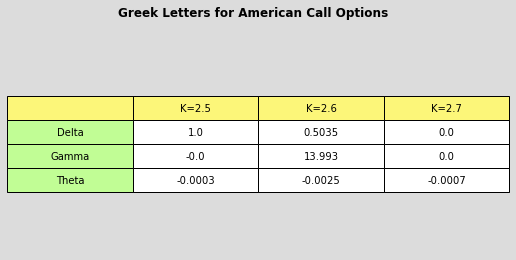

In [272]:
table_greek_american=[
['Delta',
np.round(american_delta_k_1,4),
np.round(american_delta_k_2,4),
np.round(american_delta_k_3,4)],
['Gamma',
np.round(american_gamma_k_1,4),
np.round(american_gamma_k_2,4),
np.round(american_gamma_k_3,4)],
['Theta',
np.round(american_theta_k_1,4),
np.round(american_theta_k_2,4),
np.round(american_theta_k_3,4)]]
column_headers=['',"K=2.5","K=2.6","K=2.7"]
cell_color=[['xkcd:celery','white','white','white'],
['xkcd:celery','white','white','white'],
['xkcd:celery','white','white','white']]
fig, ax = plt.subplots(facecolor='gainsboro') 
ax.set_axis_off() 
the_table = ax.table(cellText=table_greek_american,
                      colColours=['xkcd:straw']*4,
                      colLabels=column_headers,
                      loc='center',
                      cellLoc='center',
                      cellColours=cell_color)
plt.suptitle('Greek Letters for American Call Options', fontweight ="bold") 
the_table.scale(1.5, 2)

Total

In [273]:
table_greek_euo_ame=[["K=2.5(E)","K=2.6(E)","K=2.7(E)","K=2.5(A)","K=2.6(A)","K=2.7(A)"],
["Delta",
np.round(european_delta_k_1,4),
np.round(european_delta_k_2,4),
np.round(european_delta_k_3,4),
np.round(american_delta_k_1,4),
np.round(american_delta_k_2,4),
np.round(american_delta_k_3,4)],
["Gamma",
np.round(european_gamma_k_1,4),
np.round(european_gamma_k_2,4),
np.round(european_gamma_k_3,4),
np.round(american_gamma_k_1,4),
np.round(american_gamma_k_2,4),
np.round(american_gamma_k_3,4)],
["Theta",
np.round(european_theta_k_1,4),
np.round(european_theta_k_2,4),
np.round(european_theta_k_3,4),
np.round(american_theta_k_1,4),
np.round(american_theta_k_2,4),
np.round(american_theta_k_3,4)],
["Vega",
np.round(european_vega_k_1,4),
np.round(european_vega_k_2,4),
np.round(european_vega_k_3,4),
np.round(american_vega_k_1,4),
np.round(american_vega_k_2,4),
np.round(american_vega_k_3,4)]]
print(tabulate(table_greek_euo_ame, headers='firstrow', tablefmt='fancy_grid'))

╒═══════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╕
│       │   K=2.5(E) │   K=2.6(E) │   K=2.7(E) │   K=2.5(A) │   K=2.6(A) │   K=2.7(A) │
╞═══════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ Delta │     0.7201 │     0.5212 │     0.3239 │     1      │     0.5035 │     0      │
├───────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│ Gamma │     1.7494 │     2.0706 │     1.868  │    -0      │    13.993  │     0      │
├───────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│ Theta │    -0.0012 │    -0.0014 │    -0.0012 │    -0.0003 │    -0.0025 │    -0.0007 │
├───────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│ Vega  │     0.0471 │     0.0558 │     0.0503 │     0.1357 │    -0.0264 │     0.0878 │
╘═══════╧════════════╧════════════╧════════════╧════════════╧════════════╧════════════╛


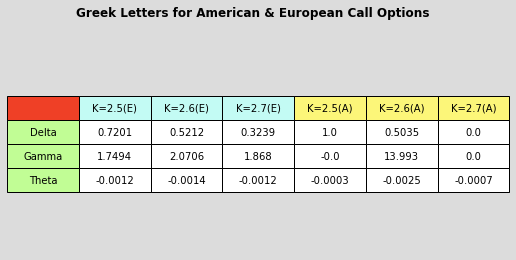

In [274]:
table_greek_euo_ame=[
['Delta',
np.round(european_delta_k_1,4),
np.round(european_delta_k_2,4),
np.round(european_delta_k_3,4),
np.round(american_delta_k_1,4),
np.round(american_delta_k_2,4),
np.round(american_delta_k_3,4)],
['Gamma',
np.round(european_gamma_k_1,4),
np.round(european_gamma_k_2,4),
np.round(european_gamma_k_3,4),
np.round(american_gamma_k_1,4),
np.round(american_gamma_k_2,4),
np.round(american_gamma_k_3,4)],
['Theta',
np.round(european_theta_k_1,4),
np.round(european_theta_k_2,4),
np.round(european_theta_k_3,4),
np.round(american_theta_k_1,4),
np.round(american_theta_k_2,4),
np.round(american_theta_k_3,4)]]
column_headers=['',"K=2.5(E)","K=2.6(E)","K=2.7(E)","K=2.5(A)","K=2.6(A)","K=2.7(A)"]
cell_color=[['xkcd:celery','white','white','white','white','white','white'],
['xkcd:celery','white','white','white','white','white','white'],
['xkcd:celery','white','white','white','white','white','white']]
fig, ax = plt.subplots(facecolor='gainsboro') 
ax.set_axis_off() 
the_table = ax.table(cellText=table_greek_euo_ame,
                      colColours=['xkcd:tomato']+['xkcd:duck egg blue']*3+['xkcd:straw']*3,
                      colLabels=column_headers,
                      loc='center',
                      cellLoc='center',
                      cellColours=cell_color)
plt.suptitle('Greek Letters for American & European Call Options', fontweight ="bold") 
the_table.scale(1.5, 2)

### Simulation (Additional Thinking)

#### Delta

In [275]:
S0_simulation=np.linspace(1,4,500)
delta_simu_euro_k_1=european_delta_cal(S0_simulation, k_1, T2, risk_free, asset_volatility)
delta_simu_euro_k_2=european_delta_cal(S0_simulation, k_2, T2, risk_free, asset_volatility)
delta_simu_euro_k_3=european_delta_cal(S0_simulation, k_3, T2, risk_free, asset_volatility)
delta_simu_ame_k_1=np.zeros(500)
delta_simu_ame_k_2=np.zeros(500)
delta_simu_ame_k_3=np.zeros(500)
for i in range(len(S0_simulation)):
    delta_simu_ame_k_1[i-1]=american_delta_cal(S0_simulation[i-1], k_1, T2, risk_free, asset_volatility, 'call', T2)
    delta_simu_ame_k_2[i-1]=american_delta_cal(S0_simulation[i-1], k_2, T2, risk_free, asset_volatility, 'call', T2)
    delta_simu_ame_k_3[i-1]=american_delta_cal(S0_simulation[i-1], k_3, T2, risk_free, asset_volatility, 'call', T2)

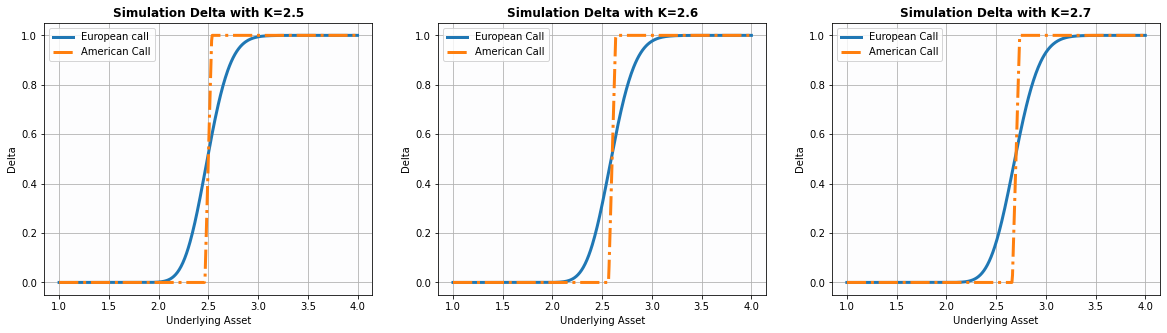

In [276]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,delta_simu_euro_k_1,linestyle="solid",linewidth=3,label='European call')
plt.plot(S0_simulation,delta_simu_ame_k_1,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Delta with K=2.5",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Delta")
plt.legend()
plt.grid()
plt.subplot(1,3,2,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,delta_simu_euro_k_2,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,delta_simu_ame_k_2,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Delta with K=2.6",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Delta")
plt.legend()
plt.grid()
plt.subplot(1,3,3,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,delta_simu_euro_k_3,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,delta_simu_ame_k_3,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Delta with K=2.7",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Delta")
plt.legend()
plt.grid()
plt.show()

#### Gamma

In [277]:
gamma_simu_euro_k_1=european_gamma_cal(S0_simulation, k_1, T2, risk_free, asset_volatility)
gamma_simu_euro_k_2=european_gamma_cal(S0_simulation, k_2, T2, risk_free, asset_volatility)
gamma_simu_euro_k_3=european_gamma_cal(S0_simulation, k_3, T2, risk_free, asset_volatility)
gamma_simu_ame_k_1=np.zeros(500)
gamma_simu_ame_k_2=np.zeros(500)
gamma_simu_ame_k_3=np.zeros(500)
for i in range(len(S0_simulation)):
    gamma_simu_ame_k_1[i-1]=american_gamma_cal(S0_simulation[i-1], k_1, T2, risk_free, asset_volatility, 'call', T)
    gamma_simu_ame_k_2[i-1]=american_gamma_cal(S0_simulation[i-1], k_2, T2, risk_free, asset_volatility, 'call', T)
    gamma_simu_ame_k_3[i-1]=american_gamma_cal(S0_simulation[i-1], k_3, T2, risk_free, asset_volatility, 'call', T)

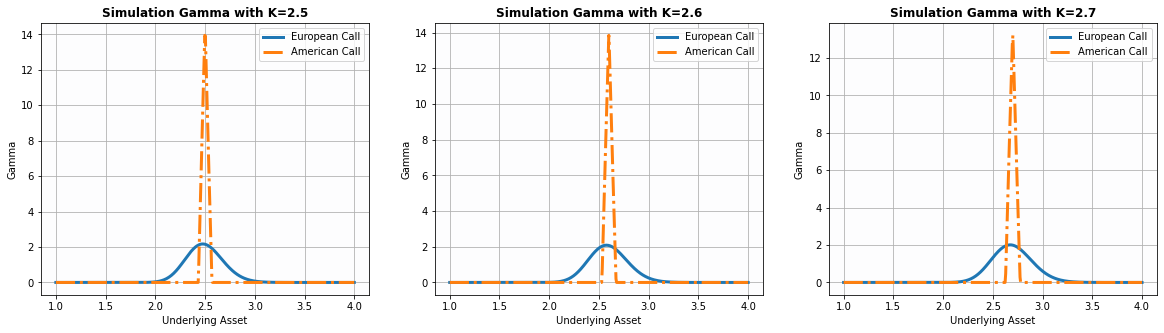

In [278]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,gamma_simu_euro_k_1,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,gamma_simu_ame_k_1,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Gamma with K=2.5",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Gamma")
plt.legend()
plt.grid()
plt.subplot(1,3,2,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,gamma_simu_euro_k_2,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,gamma_simu_ame_k_2,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Gamma with K=2.6",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Gamma")
plt.legend()
plt.grid()
plt.subplot(1,3,3,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,gamma_simu_euro_k_3,linestyle="solid",linewidth=3,label='European Call')
plt.plot(S0_simulation,gamma_simu_ame_k_3,linestyle="dashdot",linewidth=3,label='American Call')
plt.title("Simulation Gamma with K=2.7",fontweight ="bold")
plt.xlabel("Underlying Asset")
plt.ylabel("Gamma")
plt.legend()
plt.grid()
plt.show()

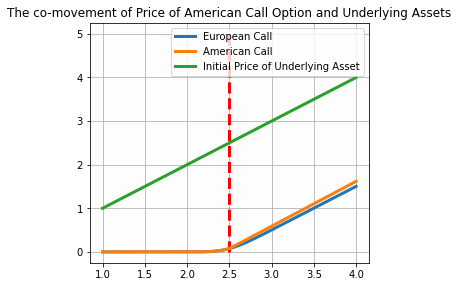

In [279]:
plt.figure(figsize=(5,15))
plt.subplot(3,1,1,facecolor='xkcd:pale grey')
plt.plot(S0_simulation,simu_euro_k_1,label="European Call",linewidth=3)
plt.plot(S0_simulation,simu_ame_k_1,label="American Call",linewidth=3)
plt.plot(S0_simulation,S0_simulation,label='Initial Price of Underlying Asset',linewidth=3)
plt.vlines(2.5,0,5,lw=2,color="red",linestyles="dashed",linewidth=3)
plt.title('The co-movement of Price of American Call Option and Underlying Assets')
plt.legend()
plt.grid()
plt.show()
#help(plt.vlines)

#### Theta

In [280]:
theta_simu_euro_k_1=european_theta_cal(S0_simulation, k_1, T2, risk_free, asset_volatility)
theta_simu_euro_k_2=european_theta_cal(S0_simulation, k_2, T2, risk_free, asset_volatility)
theta_simu_euro_k_3=european_theta_cal(S0_simulation, k_3, T2, risk_free, asset_volatility)
theta_simu_ame_k_1=np.zeros(500)
theta_simu_ame_k_2=np.zeros(500)
theta_simu_ame_k_3=np.zeros(500)
for i in range(len(S0_simulation)):
    theta_simu_ame_k_1[i-1]=american_theta_cal(S0_simulation[i-1], k_1, T2, risk_free, asset_volatility, 'call', T2)
    theta_simu_ame_k_2[i-1]=american_theta_cal(S0_simulation[i-1], k_2, T2, risk_free, asset_volatility, 'call', T2)
    theta_simu_ame_k_3[i-1]=american_theta_cal(S0_simulation[i-1], k_3, T2, risk_free, asset_volatility, 'call', T2)

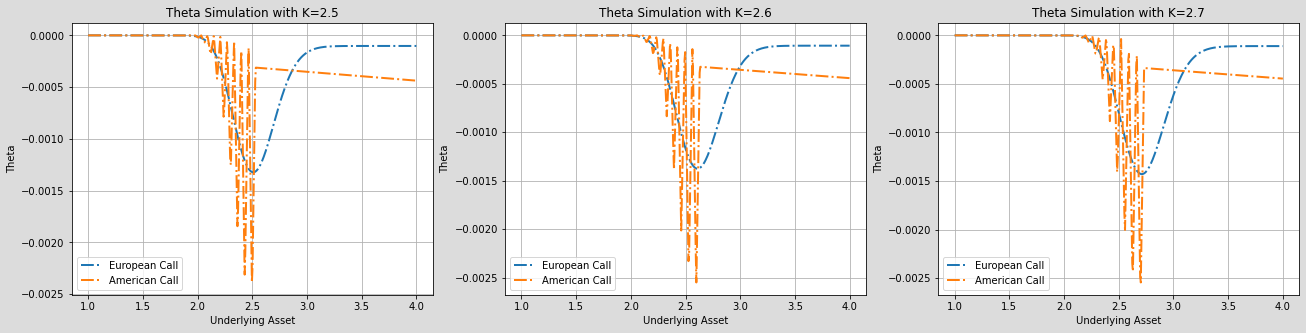

In [281]:
plt.figure(figsize=(22,5),facecolor='gainsboro')
plt.subplot(1,3,1)
plt.plot(S0_simulation,theta_simu_euro_k_1,linestyle="dashdot",linewidth=2,label='European Call')
plt.plot(S0_simulation,theta_simu_ame_k_1,linestyle="dashdot",linewidth=2,label='American Call')
plt.title("Theta Simulation with K=2.5")
plt.xlabel("Underlying Asset")
plt.ylabel("Theta")
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(S0_simulation,theta_simu_euro_k_2,linestyle="dashdot",linewidth=2,label='European Call')
plt.plot(S0_simulation,theta_simu_ame_k_2,linestyle="dashdot",linewidth=2,label='American Call')
plt.title("Theta Simulation with K=2.6")
plt.xlabel("Underlying Asset")
plt.ylabel("Theta")
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(S0_simulation,theta_simu_euro_k_3,linestyle="dashdot",linewidth=2,label='European Call')
plt.plot(S0_simulation,theta_simu_ame_k_3,linestyle="dashdot",linewidth=2,label='American Call')
plt.title("Theta Simulation with K=2.7")
plt.xlabel("Underlying Asset")
plt.ylabel("Theta")
plt.legend()
plt.grid()
plt.show()

In [282]:
t=np.arange(1,T2+1)
theta_simu_euro_k_1_time=european_theta_cal(S0, k_1, t, risk_free, asset_volatility)
theta_simu_euro_k_2_time=european_theta_cal(S0, k_2, t, risk_free, asset_volatility)
theta_simu_euro_k_3_time=european_theta_cal(S0, k_3, t, risk_free, asset_volatility)
theta_simu_ame_k_1_time=np.zeros(T2)
theta_simu_ame_k_2_time=np.zeros(T2)
theta_simu_ame_k_3_time=np.zeros(T2)
for i in range(len(t)):
    theta_simu_ame_k_1_time[i]=american_theta_cal(S0, k_1, t[i], risk_free, asset_volatility, 'call', t[i])
    theta_simu_ame_k_2_time[i]=american_theta_cal(S0, k_2, t[i], risk_free, asset_volatility, 'call', t[i])
    theta_simu_ame_k_3_time[i]=american_theta_cal(S0, k_3, t[i], risk_free, asset_volatility, 'call', t[i])

C:\Users\lenovo\AppData\Local\Temp/ipykernel_7404/424253101.py:4: RuntimeWarning: invalid value encountered in long_scalars
  dt = T / M  # length of time interval


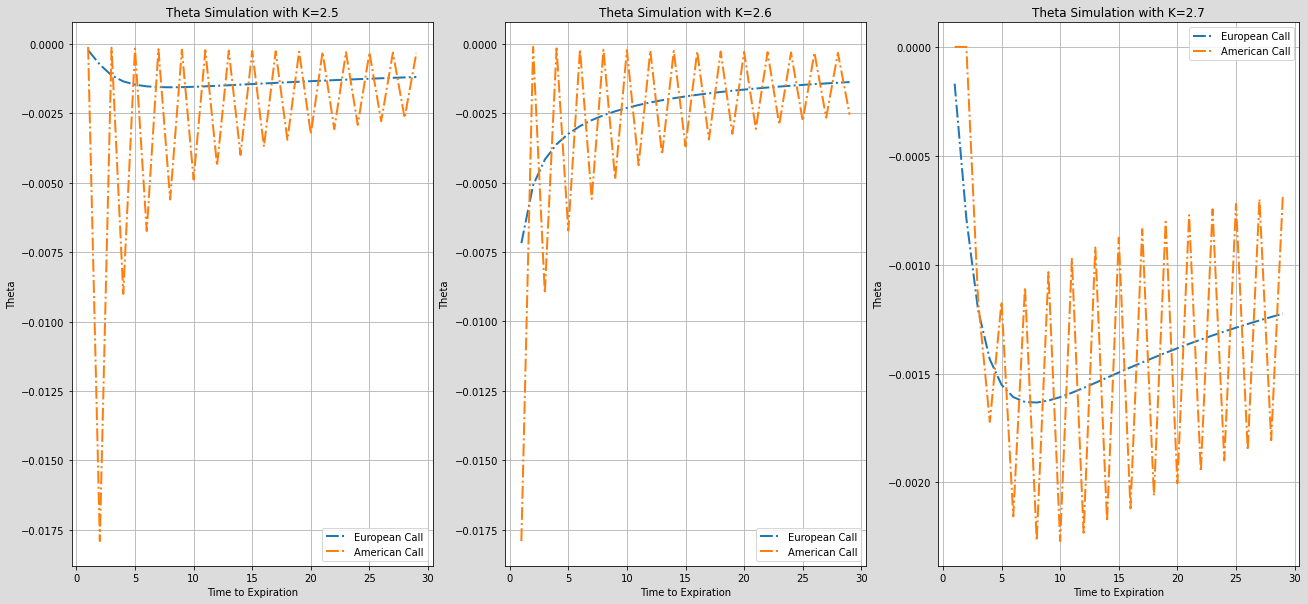

In [283]:
plt.figure(figsize=(22,10),facecolor='gainsboro')
plt.subplot(1,3,1)
plt.plot(t,theta_simu_euro_k_1_time,linestyle="dashdot",linewidth=2,label='European Call')
plt.plot(t,theta_simu_ame_k_1_time,linestyle="dashdot",linewidth=2,label='American Call')
plt.title("Theta Simulation with K=2.5")
plt.xlabel("Time to Expiration")
plt.ylabel("Theta")
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(t,theta_simu_euro_k_2_time,linestyle="dashdot",linewidth=2,label='European Call')
plt.plot(t,theta_simu_ame_k_2_time,linestyle="dashdot",linewidth=2,label='American Call')
plt.title("Theta Simulation with K=2.6")
plt.xlabel("Time to Expiration")
plt.ylabel("Theta")
plt.legend(loc='lower right')
plt.grid()
plt.subplot(1,3,3)
plt.plot(t,theta_simu_euro_k_3_time,linestyle="dashdot",linewidth=2,label='European Call')
plt.plot(t,theta_simu_ame_k_3_time,linestyle="dashdot",linewidth=2,label='American Call')
plt.title("Theta Simulation with K=2.7")
plt.xlabel("Time to Expiration")
plt.ylabel("Theta")
plt.legend()
plt.grid()
plt.show()

In [284]:
k=np.linspace(2,4,100)
t=np.arange(1,T2+1)
theta_simu_euro_k_t0=european_theta_cal(S0, k, t[0], risk_free, asset_volatility)
theta_simu_euro_k_t1=european_theta_cal(S0, k, t[1], risk_free, asset_volatility)
theta_simu_euro_k_t2=european_theta_cal(S0, k, t[2], risk_free, asset_volatility)
theta_simu_euro_k_t3=european_theta_cal(S0, k, t[3], risk_free, asset_volatility)
theta_simu_ame_k_t0=np.zeros(100)
theta_simu_ame_k_t1=np.zeros(100)
theta_simu_ame_k_t2=np.zeros(100)
theta_simu_ame_k_t3=np.zeros(100)
for i in range(len(k)):
    theta_simu_ame_k_t0[i-1]=american_theta_cal(S0, k[i-1], t[0], risk_free, asset_volatility, 'call', T2)
    theta_simu_ame_k_t1[i-1]=american_theta_cal(S0, k[i-1], t[1], risk_free, asset_volatility, 'call', T2)
    theta_simu_ame_k_t2[i-1]=american_theta_cal(S0, k[i-1], t[2], risk_free, asset_volatility, 'call', T2)
    theta_simu_ame_k_t3[i-1]=american_theta_cal(S0, k[i-1], t[3], risk_free, asset_volatility, 'call', T2)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_7404/424253101.py:11: RuntimeWarning: invalid value encountered in double_scalars
  q = (np.exp(r * dt) - d) / (u - d)  # martingale branch probability


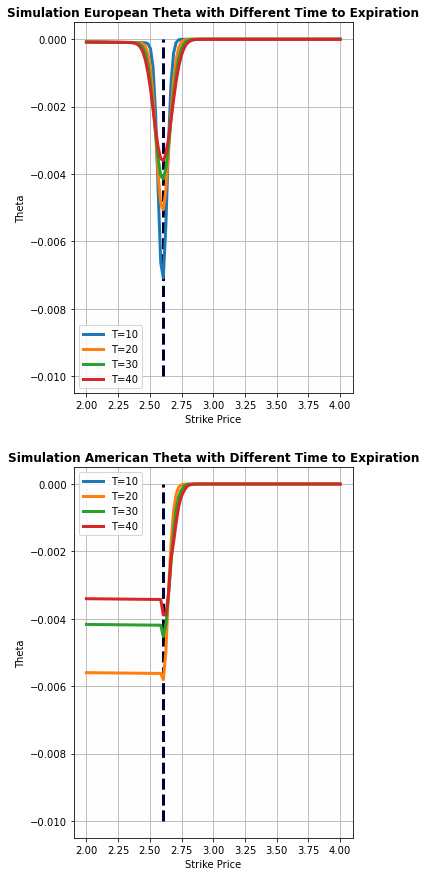

In [285]:
plt.figure(figsize=(5,15))
plt.subplot(2,1,1,facecolor='xkcd:pale grey')
plt.plot(k,theta_simu_euro_k_t0,linestyle="solid",linewidth=3,label='T=10')
plt.plot(k,theta_simu_euro_k_t1,linestyle="solid",linewidth=3,label='T=20')
plt.plot(k,theta_simu_euro_k_t2,linestyle="solid",linewidth=3,label='T=30')
plt.plot(k,theta_simu_euro_k_t3,linestyle="solid",linewidth=3,label='T=40')
plt.title("Simulation European Theta with Different Time to Expiration",fontweight ="bold")
plt.vlines(2.6,-0.01,0,lw=2,color="xkcd:very dark blue",linestyles="dashed",linewidth=3)
plt.xlabel("Strike Price")
plt.ylabel("Theta")
plt.legend()
plt.grid()
plt.subplot(2,1,2,facecolor='xkcd:pale grey')
plt.plot(k,theta_simu_ame_k_t0,linestyle="solid",linewidth=3,label='T=10')
plt.plot(k,theta_simu_ame_k_t1,linestyle="solid",linewidth=3,label='T=20')
plt.plot(k,theta_simu_ame_k_t2,linestyle="solid",linewidth=3,label='T=30')
plt.plot(k,theta_simu_ame_k_t3,linestyle="solid",linewidth=3,label='T=40')
plt.title("Simulation American Theta with Different Time to Expiration",fontweight ="bold")
plt.vlines(2.6,-0.01,0,lw=2,color="xkcd:very dark blue",linestyles="dashed",linewidth=3)
plt.xlabel("Strike Price")
plt.ylabel("Theta")
plt.legend()
plt.grid()

#### Vega

In [286]:
k=np.linspace(2,4,100)
t=np.linspace(10,40,4)
vega_simu_euro_k_t0=european_vega_cal(S0, k, t[0], risk_free, asset_volatility)
vega_simu_euro_k_t1=european_vega_cal(S0, k, t[1], risk_free, asset_volatility)
vega_simu_euro_k_t2=european_vega_cal(S0, k, t[2], risk_free, asset_volatility)
vega_simu_euro_k_t3=european_vega_cal(S0, k, t[3], risk_free, asset_volatility)
vega_simu_ame_k_t0=np.zeros(100)
vega_simu_ame_k_t1=np.zeros(100)
vega_simu_ame_k_t2=np.zeros(100)
vega_simu_ame_k_t3=np.zeros(100)
for i in range(len(k)):
    vega_simu_ame_k_t0[i-1]=american_vega_cal(S0, k[i-1], t[0], risk_free, asset_volatility, 'call', T2)
    vega_simu_ame_k_t1[i-1]=american_vega_cal(S0, k[i-1], t[1], risk_free, asset_volatility, 'call', T2)
    vega_simu_ame_k_t2[i-1]=american_vega_cal(S0, k[i-1], t[2], risk_free, asset_volatility, 'call', T2)
    vega_simu_ame_k_t3[i-1]=american_vega_cal(S0, k[i-1], t[3], risk_free, asset_volatility, 'call', T2)
    

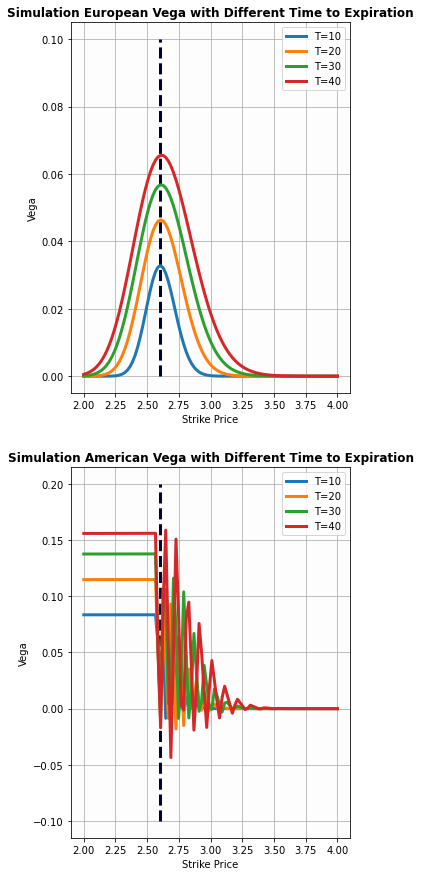

In [287]:
plt.figure(figsize=(5,15))
plt.subplot(2,1,1,facecolor='xkcd:pale grey')
plt.plot(k,vega_simu_euro_k_t0,linestyle="solid",linewidth=3,label='T=10')
plt.plot(k,vega_simu_euro_k_t1,linestyle="solid",linewidth=3,label='T=20')
plt.plot(k,vega_simu_euro_k_t2,linestyle="solid",linewidth=3,label='T=30')
plt.plot(k,vega_simu_euro_k_t3,linestyle="solid",linewidth=3,label='T=40')
plt.title("Simulation European Vega with Different Time to Expiration",fontweight ="bold")
plt.vlines(2.6,0,0.1,lw=2,color="xkcd:very dark blue",linestyles="dashed",linewidth=3)
plt.xlabel("Strike Price")
plt.ylabel("Vega")
plt.legend()
plt.grid()
plt.subplot(2,1,2,facecolor='xkcd:pale grey')
plt.plot(k,vega_simu_ame_k_t0,linestyle="solid",linewidth=3,label='T=10')
plt.plot(k,vega_simu_ame_k_t1,linestyle="solid",linewidth=3,label='T=20')
plt.plot(k,vega_simu_ame_k_t2,linestyle="solid",linewidth=3,label='T=30')
plt.plot(k,vega_simu_ame_k_t3,linestyle="solid",linewidth=3,label='T=40')
plt.title("Simulation American Vega with Different Time to Expiration",fontweight ="bold")
plt.vlines(2.6,-0.1,0.2,lw=2,color="xkcd:very dark blue",linestyles="dashed",linewidth=3)
plt.xlabel("Strike Price")
plt.ylabel("Vega")
plt.legend()
plt.grid()

### Implied Volatility

In [288]:
def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = target_value - price  # 我们的根

        #print i, sigma, diff

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # 未找到值，返回迄今为止的最佳猜测
    return sigma

n = norm.pdf
N = norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    if cp_flag == 'c':
        price = S*np.exp(-q*T)*N(d1)-K*np.exp(-r*T)*N(d2)
    else:
        price = K*np.exp(-r*T)*N(-d2)-S*np.exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    return S * np.sqrt(T)*n(d1)

In [289]:
implied_vol_k1 = find_vol(data.iloc[3,1], "c", S0, k_1, T1, risk_free)
implied_vol_k2 = find_vol(data.iloc[3,2], "c", S0, k_2, T1, risk_free)
implied_vol_k3 = find_vol(data.iloc[3,3], "c", S0, k_3, T1, risk_free)
fair_price=coc_euro_price_fair_cal(S0=S0, K=2.5, T=T2, r=risk_free, sigma=implied_vol_k1, otype='call', M=T2)
print("The value of European Compunded Call option with K=2.5 is",np.round(coc_euro_price(S0=S0,K1=0.05,alpha=2.5/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k1, otype='call',M=T2),4))
print("The value of European Compunded Call option with K=2.65 is",np.round(coc_euro_price(S0=S0,K1=0.05,alpha=2.65/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k2, otype='call',M=T2),4))
print("The value of European Compunded Call option with K=2.8 is",np.round(coc_euro_price(S0=S0,K1=0.05,alpha=2.8/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k3, otype='call',M=T2),4))

The value of European Compunded Call option with K=2.5 is 0.2697
The value of European Compunded Call option with K=2.65 is 0.125
The value of European Compunded Call option with K=2.8 is 0.0448


In [290]:
table_implied_volatility=[["K=2.5","K=2.6","K=2.7","Asset"],
["Volatility",
np.round(implied_vol_k1,4),
np.round(implied_vol_k2,4),
np.round(implied_vol_k3,4),
np.round(asset_volatility,4)]]
print(tabulate(table_implied_volatility, headers='firstrow', tablefmt='fancy_grid'))

╒════════════╤═════════╤═════════╤═════════╤═════════╕
│            │   K=2.5 │   K=2.6 │   K=2.7 │   Asset │
╞════════════╪═════════╪═════════╪═════════╪═════════╡
│ Volatility │  0.0478 │  0.0337 │  0.0276 │  0.0137 │
╘════════════╧═════════╧═════════╧═════════╧═════════╛


In [291]:
table_implied_volatility_optionprice=[["K=2.5","K=2.6","K=2.7"],
["European Call (Implied Volatility)",
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.5/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k1, otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.65/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k2, otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.8/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k3, otype='call',M=T2),4)],
["European Call (Asset Volatility)",
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.5/fair_price,T1=T1,T2=T2,r=risk_free, sigma=asset_volatility, otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.65/fair_price,T1=T1,T2=T2,r=risk_free, sigma=asset_volatility, otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.8/fair_price,T1=T1,T2=T2,r=risk_free, sigma=asset_volatility, otype='call',M=T2),4)]]
print(tabulate(table_implied_volatility_optionprice, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════════════════╤═════════╤═════════╤═════════╕
│                                    │   K=2.5 │   K=2.6 │   K=2.7 │
╞════════════════════════════════════╪═════════╪═════════╪═════════╡
│ European Call (Implied Volatility) │  0.3179 │  0.1698 │  0.0812 │
├────────────────────────────────────┼─────────┼─────────┼─────────┤
│ European Call (Asset Volatility)   │  0.138  │  0.0567 │  0.0172 │
╘════════════════════════════════════╧═════════╧═════════╧═════════╛


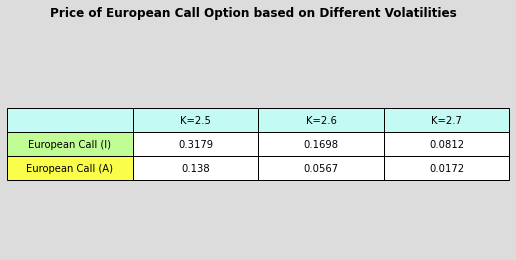

In [292]:
table_implied_volatility_optionprice=[
["European Call (I)",
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.5/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k1, otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.65/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k2, otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.8/fair_price,T1=T1,T2=T2,r=risk_free, sigma=implied_vol_k3, otype='call',M=T2),4)],
["European Call (A)",
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.5/fair_price,T1=T1,T2=T2,r=risk_free, sigma=asset_volatility, otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.65/fair_price,T1=T1,T2=T2,r=risk_free, sigma=asset_volatility, otype='call',M=T2),4),
np.round(coc_euro_price(S0=S0,K1=0,alpha=2.8/fair_price,T1=T1,T2=T2,r=risk_free, sigma=asset_volatility, otype='call',M=T2),4)],
]
column_headers=['',"K=2.5","K=2.6","K=2.7"]
cell_color=[['xkcd:celery','white','white','white'],
['xkcd:banana yellow','white','white','white']]
#['xkcd:pale lavender','white','white','white']]
fig, ax = plt.subplots(facecolor='gainsboro') 
ax.set_axis_off() 
the_table = ax.table(cellText=table_implied_volatility_optionprice,
                      colColours=['xkcd:duck egg blue']*4,
                      colLabels=column_headers,
                      loc='center',
                      cellLoc='center',
                      cellColours=cell_color)
plt.suptitle('Price of European Call Option based on Different Volatilities', fontweight ="bold") 
the_table.scale(1.5, 2)